In [4]:
import json
import time
import os
import re

from modules.preprocessing_protocols import preprocess_text
from modules.tools import find

from estnltk import Text
from estnltk.taggers import NerTagger
from estnltk.converters import text_to_json
from estnltk.converters import json_to_text
from estnltk.layer_operations import flatten

from estnltk.taggers.estner.ner_trainer import NerTrainer
from estnltk.taggers.estner.model_storage_util import ModelStorageUtil

from estnltk.converters import json_to_text
from nervaluate import Evaluator

from estnltk.taggers import VabamorfCorpusTagger
vm_corpus_tagger = VabamorfCorpusTagger()

### Flags & variables:

In [3]:
use_vabamorfcorpustagger = False

In [1]:
divided_corpus = os.path.join('..', 'data', 'divided_corpus.txt')
json_files_location = os.path.join('..', 'data', 'vallakohtufailid-json-flattened')
vallakohtufailid_location = os.path.join('..', 'data', 'vallakohtufailid')
no_goldstandard_tags_location = os.path.join('..', 'data', 'files_without_goldstandard_annotations.txt')

removed_layers = ['sentences', 'morph_analysis', 'compound_tokens', 'ner', 'words', 'tokens']

NameError: name 'os' is not defined

---

In [4]:
files = {}

with open(divided_corpus, 'r', encoding = 'UTF-8') as in_f:
    txt = in_f.readlines()

for filename in txt:
    file, subdistribution = filename.split(":")
    files[file] = subdistribution.strip()

In [5]:
files_not_working = ['J2rva_Tyri_V22tsa_id22177_1911a.json', \
                     'J2rva_Tyri_V22tsa_id18538_1894a.json', \
                     'J2rva_Tyri_V22tsa_id22155_1911a.json', \
                     'Saare_Kihelkonna_Kotlandi_id18845_1865a.json', \
                     'P2rnu_Halliste_Abja_id257_1844a.json', \
                     'Saare_Kaarma_Loona_id7575_1899a.json', \
                     'J2rva_Tyri_V22tsa_id22266_1913a.json', \
                     'J2rva_Tyri_V22tsa_id22178_1912a.json']

In [6]:
def results_by_subdistribution(results_json):
    df = dict()
    
    correct = results_json[0]['strict']['correct']
    actual = results_json[0]['strict']['actual']
    possible = results_json[0]['strict']['possible']

    precision = (correct / actual)
    recall = (correct / possible)
    f1 = 2 * ((precision * recall) / (precision + recall))
    
    return [precision, recall, f1]

In [6]:
def extract_results_to_txt_file(model_dir, files):
    all_results = {}
    
    gold_ner = []
    test_ner = []
    
    for file in files:
        if file not in os.listdir(os.path.join('models', model_dir, 'vallakohtufailid-trained-nertagger_v2')):
            continue
        appendable_gold_ner = []
        appendable_test_ner = []

        if not file.endswith(".json") or file in files_not_working:
            continue
        else:
            with open(os.path.join('models', model_dir, 'vallakohtufailid-trained-nertagger', file), 'r', encoding='UTF-8') as f_test, \
                 open(os.path.join('..', 'data', 'vallakohtufailid-json-flattened', file), 'r', encoding='UTF-8') as f_gold:
                    test_import = json_to_text(f_test.read())
                    gold_import = json_to_text(f_gold.read())

                    for i in range(len(gold_import['gold_ner'])):
                        ner = gold_import['gold_ner'][i]
                        label = ner.nertag
                        start = int(ner.start)
                        end = int(ner.end)
                        appendable_gold_ner.append({"label": label, "start": start, "end": end})

                    for i in range(len(test_import['flat_ner'])):
                        ner = test_import['flat_ner'][i]
                        label = ner.nertag[0]
                        start = int(ner.start)
                        end = int(ner.end)
                        appendable_test_ner.append({"label": label, "start": start, "end": end})

        gold_ner.append(appendable_gold_ner)
        test_ner.append(appendable_test_ner)
    evaluator = Evaluator(gold_ner, test_ner, tags=['ORG', 'PER', 'MISC', 'LOC', 'LOC_ORG'])
    results, results_per_tag = evaluator.evaluate()
    all_results = (results, results_per_tag)
    print("Tulemuste ammutamine on lõpetatud.")
    
    return all_results

In [7]:
def create_training_texts(filenames):
    print("(!) Valmistan ette treenimistekste")
    
    # These files don't work because the protocols are written in a different language,
    # which the goldstandard didn't recognise, hence have no goldstandard tags.
    files_not_working = ['J2rva_Tyri_V22tsa_id22177_1911a.json', \
                         'J2rva_Tyri_V22tsa_id18538_1894a.json', \
                         'J2rva_Tyri_V22tsa_id22155_1911a.json', \
                         'Saare_Kihelkonna_Kotlandi_id18845_1865a.json', \
                         'P2rnu_Halliste_Abja_id257_1844a.json', \
                         'Saare_Kaarma_Loona_id7575_1899a.json', \
                         'J2rva_Tyri_V22tsa_id22266_1913a.json', \
                         'J2rva_Tyri_V22tsa_id22178_1912a.json']
    
    start = time.time()
    training_texts = []
    for filename in filenames:
        with open(os.path.join('..', 'data', 'vallakohtufailid-json-flattened', filename), 'r', encoding='UTF-8') as file:
            if filename in files_not_working:
                continue
            else:
                tagged_text = preprocess_text(json_to_text(file.read()))
                if use_vabamorfcorpustagger:
                    tagged_text.pop_layer('morph_analysis')
                    vm_corpus_tagger.tag([tagged_text])
                training_texts.append(tagged_text)
    print(f"(!) Treenimistekstid ette valmistatud {time.time() - start} sekundiga")
    return training_texts

In [8]:
def train_nertagger(training_texts, new_model_dir):
    print("(!) Treenin NerTaggerit")
    start = time.time()
    
    modelUtil = ModelStorageUtil( new_model_dir )
    nersettings = modelUtil.load_settings()
    trainer = NerTrainer(nersettings)
    trainer.train( training_texts, layer='gold_wordner', model_dir=new_model_dir )
    print(f"(!) NerTagger treenitud {time.time() - start} sekundiga")

In [9]:
def tag_files(model_dir, testing_files, use_vabamorfcorpustagger):
    removed_layers = ['sentences', 'morph_analysis', 'compound_tokens', 'ner', 'words', 'tokens']
    nertagger = NerTagger(model_dir)
    
    print("(!) Märgendan")
    start = time.time()
    iterator = 1
    for test_file in testing_files:
        with open(find(test_file.replace(".json", ".txt"), os.path.join('..', 'data', 'vallakohtufailid')), 'r', encoding='UTF-8') as f:
            text = f.read()
        
        if test_file == "Tartu_V6nnu_Ahja_id3502_1882a.json":
            text = text.replace('..', '. .')
        text = preprocess_text(Text(text))

        if use_vabamorfcorpustagger or "vabamorf" in model_dir:
            text.pop_layer('morph_analysis')
            text = [text]
            vm_corpus_tagger.tag( text )
            text = text[0]
        nertagger.tag(text)
        text.add_layer(flatten(text['ner'], 'flat_ner'))

        for x in removed_layers:
            text.pop_layer(x)

        path = os.path.join(model_dir, 'vallakohtufailid-trained-nertagger')
        if not os.path.exists(path):
            os.mkdir(path)
            
        text_to_json(text, file=os.path.join(model_dir, 'vallakohtufailid-trained-nertagger', test_file))
        
        print(f'{iterator}. Märgendatud fail {test_file}')
        iterator += 1
    print(f"(!) Failid märgendatud {time.time() - start} sekundiga")


In [10]:
testing_files = []
with open(os.path.join('..', 'data', 'corpus_subdistribution_without_hand_tagged.txt'), 'r', encoding='UTF-8') as in_f:
    lines = in_f.readlines()

for line in lines:
    file, dist = line.strip().split(':')
    testing_files.append(file)

In [11]:
def train_model(model_directory, increment):
    initial = increment
    running = True
    while running:
        filenames = [key for key, value in files.items()]
        
        if len(filenames) < increment:
            increment += len(filenames) - increment - 1
            running = False
        filenames = filenames[:increment]

        # Create training_texts from the files
        training_texts = create_training_texts(filenames) 
        
        # Set up the trainer and training
        new_model_dir = os.path.join('models', model_directory)
        train_nertagger(training_texts, new_model_dir)

        # Set up the new trained nertagger and defining layers to be removed later on
        tagger = NerTagger(model_dir = new_model_dir)

        # Tag the files using the new nertagger
        tag_files(new_model_dir, testing_files, use_vabamorfcorpustagger)

        all_results = extract_results_to_txt_file(model_directory, testing_files)
        
        with open(os.path.join('models', model_directory, 'results', f'results{increment}.txt'), 'w+', encoding='UTF-8') as out_f:
            out_f.write(json.dumps(all_results))
        
        increment += initial
        
    print(f"(!) Mudel {model_directory} treenitud")

To train the model the `model_directory` must contain a `settings.py` file

In [12]:
train_model(os.path.join('model_morph_with_lemmas_and_sentences_and_gazetteer_and_global_features', 'model_gaz_loc_variants_quantity'), 100)

(!) Valmistan ette treenimistekste
(!) Treenimistekstid ette valmistatud 12.237100839614868 sekundiga
(!) Treenin NerTaggerit
(!) Warning: Location of the new "settings.py" is the same one as the old one. Model's settings are not copied.
Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 0
0....1....2....3....4....5....6....7....8....9....10
Number of features: 69429
Seconds required: 0.167

Stochastic Gradient Descent (SGD)
c2: 0.001000
max_iterations: 1000
period: 10
delta: 0.000001

Calibrating the learning rate (eta)
calibration.eta: 0.100000
calibration.rate: 2.000000
calibration.samples: 1000
calibration.candidates: 10
calibration.max_trials: 20
Initial loss: 35570.378477
Trial #1 (eta = 0.100000): 4373.861925
Trial #2 (eta = 0.200000): 7762.202074
Trial #3 (eta = 0.400000): 14257.758443
Trial #4 (eta = 0.800000): 33317.666778
Trial #5 (eta = 1.600000): ERROR: overflow loss
nan (worse)
Trial #6 (eta = 0.050000): 3295.

***** Epoch #38 *****
Loss: 107.065254
Improvement ratio: 0.382579
Feature L2-norm: 37.010522
Learning rate (eta): 0.024953
Total number of feature updates: 61522
Seconds required for this iteration: 0.049

***** Epoch #39 *****
Loss: 104.694531
Improvement ratio: 0.363558
Feature L2-norm: 37.241883
Learning rate (eta): 0.024951
Total number of feature updates: 63141
Seconds required for this iteration: 0.049

***** Epoch #40 *****
Loss: 102.006609
Improvement ratio: 0.350581
Feature L2-norm: 37.469047
Learning rate (eta): 0.024950
Total number of feature updates: 64760
Seconds required for this iteration: 0.055

***** Epoch #41 *****
Loss: 99.205570
Improvement ratio: 0.341005
Feature L2-norm: 37.690897
Learning rate (eta): 0.024949
Total number of feature updates: 66379
Seconds required for this iteration: 0.054

***** Epoch #42 *****
Loss: 97.018176
Improvement ratio: 0.326115
Feature L2-norm: 37.906178
Learning rate (eta): 0.024948
Total number of feature updates: 67998
Seconds req

***** Epoch #79 *****
Loss: 51.765946
Improvement ratio: 0.138221
Feature L2-norm: 43.557929
Learning rate (eta): 0.024902
Total number of feature updates: 127901
Seconds required for this iteration: 0.050

***** Epoch #80 *****
Loss: 51.052978
Improvement ratio: 0.138833
Feature L2-norm: 43.670225
Learning rate (eta): 0.024900
Total number of feature updates: 129520
Seconds required for this iteration: 0.049

***** Epoch #81 *****
Loss: 50.591610
Improvement ratio: 0.129635
Feature L2-norm: 43.781072
Learning rate (eta): 0.024899
Total number of feature updates: 131139
Seconds required for this iteration: 0.051

***** Epoch #82 *****
Loss: 50.012668
Improvement ratio: 0.129066
Feature L2-norm: 43.890197
Learning rate (eta): 0.024898
Total number of feature updates: 132758
Seconds required for this iteration: 0.049

***** Epoch #83 *****
Loss: 49.172103
Improvement ratio: 0.134995
Feature L2-norm: 43.998337
Learning rate (eta): 0.024897
Total number of feature updates: 134377
Seconds r

***** Epoch #120 *****
Loss: 35.713330
Improvement ratio: 0.076214
Feature L2-norm: 47.265659
Learning rate (eta): 0.024851
Total number of feature updates: 194280
Seconds required for this iteration: 0.050

***** Epoch #121 *****
Loss: 35.464557
Improvement ratio: 0.075103
Feature L2-norm: 47.338910
Learning rate (eta): 0.024850
Total number of feature updates: 195899
Seconds required for this iteration: 0.053

***** Epoch #122 *****
Loss: 35.116845
Improvement ratio: 0.076609
Feature L2-norm: 47.411495
Learning rate (eta): 0.024848
Total number of feature updates: 197518
Seconds required for this iteration: 0.051

***** Epoch #123 *****
Loss: 34.854892
Improvement ratio: 0.074574
Feature L2-norm: 47.483633
Learning rate (eta): 0.024847
Total number of feature updates: 199137
Seconds required for this iteration: 0.050

***** Epoch #124 *****
Loss: 34.605964
Improvement ratio: 0.078551
Feature L2-norm: 47.555265
Learning rate (eta): 0.024846
Total number of feature updates: 200756
Seco

***** Epoch #164 *****
Loss: 27.671229
Improvement ratio: 0.051703
Feature L2-norm: 50.014562
Learning rate (eta): 0.024797
Total number of feature updates: 265516
Seconds required for this iteration: 0.050

***** Epoch #165 *****
Loss: 27.591077
Improvement ratio: 0.042996
Feature L2-norm: 50.067626
Learning rate (eta): 0.024795
Total number of feature updates: 267135
Seconds required for this iteration: 0.050

***** Epoch #166 *****
Loss: 27.434362
Improvement ratio: 0.044698
Feature L2-norm: 50.120452
Learning rate (eta): 0.024794
Total number of feature updates: 268754
Seconds required for this iteration: 0.049

***** Epoch #167 *****
Loss: 27.235610
Improvement ratio: 0.053954
Feature L2-norm: 50.172987
Learning rate (eta): 0.024793
Total number of feature updates: 270373
Seconds required for this iteration: 0.050

***** Epoch #168 *****
Loss: 27.069095
Improvement ratio: 0.047028
Feature L2-norm: 50.225333
Learning rate (eta): 0.024792
Total number of feature updates: 271992
Seco

***** Epoch #204 *****
Loss: 23.524301
Improvement ratio: 0.033042
Feature L2-norm: 51.920886
Learning rate (eta): 0.024748
Total number of feature updates: 330276
Seconds required for this iteration: 0.049

***** Epoch #205 *****
Loss: 23.411216
Improvement ratio: 0.035024
Feature L2-norm: 51.963489
Learning rate (eta): 0.024746
Total number of feature updates: 331895
Seconds required for this iteration: 0.050

***** Epoch #206 *****
Loss: 23.296579
Improvement ratio: 0.036885
Feature L2-norm: 52.005723
Learning rate (eta): 0.024745
Total number of feature updates: 333514
Seconds required for this iteration: 0.049

***** Epoch #207 *****
Loss: 23.228444
Improvement ratio: 0.038113
Feature L2-norm: 52.047784
Learning rate (eta): 0.024744
Total number of feature updates: 335133
Seconds required for this iteration: 0.050

***** Epoch #208 *****
Loss: 23.184349
Improvement ratio: 0.034141
Feature L2-norm: 52.089733
Learning rate (eta): 0.024743
Total number of feature updates: 336752
Seco

***** Epoch #249 *****
Loss: 20.466754
Improvement ratio: 0.026355
Feature L2-norm: 53.651043
Learning rate (eta): 0.024693
Total number of feature updates: 403131
Seconds required for this iteration: 0.050

***** Epoch #250 *****
Loss: 20.360918
Improvement ratio: 0.033326
Feature L2-norm: 53.685643
Learning rate (eta): 0.024691
Total number of feature updates: 404750
Seconds required for this iteration: 0.050

***** Epoch #251 *****
Loss: 20.359492
Improvement ratio: 0.024220
Feature L2-norm: 53.720204
Learning rate (eta): 0.024690
Total number of feature updates: 406369
Seconds required for this iteration: 0.050

***** Epoch #252 *****
Loss: 20.236129
Improvement ratio: 0.026582
Feature L2-norm: 53.754632
Learning rate (eta): 0.024689
Total number of feature updates: 407988
Seconds required for this iteration: 0.050

***** Epoch #253 *****
Loss: 20.208320
Improvement ratio: 0.025843
Feature L2-norm: 53.788768
Learning rate (eta): 0.024688
Total number of feature updates: 409607
Seco

***** Epoch #289 *****
Loss: 18.602853
Improvement ratio: 0.019692
Feature L2-norm: 54.934428
Learning rate (eta): 0.024644
Total number of feature updates: 467891
Seconds required for this iteration: 0.050

***** Epoch #290 *****
Loss: 18.463415
Improvement ratio: 0.024039
Feature L2-norm: 54.964086
Learning rate (eta): 0.024643
Total number of feature updates: 469510
Seconds required for this iteration: 0.050

***** Epoch #291 *****
Loss: 18.498936
Improvement ratio: 0.020487
Feature L2-norm: 54.993745
Learning rate (eta): 0.024641
Total number of feature updates: 471129
Seconds required for this iteration: 0.051

***** Epoch #292 *****
Loss: 18.414833
Improvement ratio: 0.020901
Feature L2-norm: 55.023035
Learning rate (eta): 0.024640
Total number of feature updates: 472748
Seconds required for this iteration: 0.049

***** Epoch #293 *****
Loss: 18.470228
Improvement ratio: 0.018707
Feature L2-norm: 55.052335
Learning rate (eta): 0.024639
Total number of feature updates: 474367
Seco

***** Epoch #330 *****
Loss: 17.132797
Improvement ratio: 0.014440
Feature L2-norm: 56.069826
Learning rate (eta): 0.024594
Total number of feature updates: 534270
Seconds required for this iteration: 0.050

***** Epoch #331 *****
Loss: 17.155921
Improvement ratio: 0.018917
Feature L2-norm: 56.095539
Learning rate (eta): 0.024593
Total number of feature updates: 535889
Seconds required for this iteration: 0.049

***** Epoch #332 *****
Loss: 17.016246
Improvement ratio: 0.021103
Feature L2-norm: 56.121283
Learning rate (eta): 0.024592
Total number of feature updates: 537508
Seconds required for this iteration: 0.049

***** Epoch #333 *****
Loss: 17.093881
Improvement ratio: 0.018092
Feature L2-norm: 56.146832
Learning rate (eta): 0.024591
Total number of feature updates: 539127
Seconds required for this iteration: 0.050

***** Epoch #334 *****
Loss: 17.085932
Improvement ratio: 0.011716
Feature L2-norm: 56.172272
Learning rate (eta): 0.024589
Total number of feature updates: 540746
Seco

***** Epoch #380 *****
Loss: 15.874611
Improvement ratio: 0.012206
Feature L2-norm: 57.266890
Learning rate (eta): 0.024534
Total number of feature updates: 615220
Seconds required for this iteration: 0.049

***** Epoch #381 *****
Loss: 15.856838
Improvement ratio: 0.013947
Feature L2-norm: 57.289062
Learning rate (eta): 0.024533
Total number of feature updates: 616839
Seconds required for this iteration: 0.050

***** Epoch #382 *****
Loss: 15.742570
Improvement ratio: 0.022132
Feature L2-norm: 57.311108
Learning rate (eta): 0.024531
Total number of feature updates: 618458
Seconds required for this iteration: 0.051

***** Epoch #383 *****
Loss: 15.766922
Improvement ratio: 0.012262
Feature L2-norm: 57.333285
Learning rate (eta): 0.024530
Total number of feature updates: 620077
Seconds required for this iteration: 0.051

***** Epoch #384 *****
Loss: 15.752864
Improvement ratio: 0.017224
Feature L2-norm: 57.355269
Learning rate (eta): 0.024529
Total number of feature updates: 621696
Seco

***** Epoch #425 *****
Loss: 14.993249
Improvement ratio: 0.013010
Feature L2-norm: 58.208723
Learning rate (eta): 0.024480
Total number of feature updates: 688075
Seconds required for this iteration: 0.050

***** Epoch #426 *****
Loss: 14.906088
Improvement ratio: 0.016882
Feature L2-norm: 58.228252
Learning rate (eta): 0.024479
Total number of feature updates: 689694
Seconds required for this iteration: 0.050

***** Epoch #427 *****
Loss: 14.866059
Improvement ratio: 0.012672
Feature L2-norm: 58.248099
Learning rate (eta): 0.024477
Total number of feature updates: 691313
Seconds required for this iteration: 0.049

***** Epoch #428 *****
Loss: 14.863873
Improvement ratio: 0.018254
Feature L2-norm: 58.267796
Learning rate (eta): 0.024476
Total number of feature updates: 692932
Seconds required for this iteration: 0.050

***** Epoch #429 *****
Loss: 14.916646
Improvement ratio: 0.011238
Feature L2-norm: 58.287209
Learning rate (eta): 0.024475
Total number of feature updates: 694551
Seco

***** Epoch #469 *****
Loss: 14.241200
Improvement ratio: 0.008003
Feature L2-norm: 59.030625
Learning rate (eta): 0.024427
Total number of feature updates: 759311
Seconds required for this iteration: 0.050

***** Epoch #470 *****
Loss: 14.242032
Improvement ratio: 0.008346
Feature L2-norm: 59.048273
Learning rate (eta): 0.024426
Total number of feature updates: 760930
Seconds required for this iteration: 0.050

***** Epoch #471 *****
Loss: 14.306704
Improvement ratio: 0.006268
Feature L2-norm: 59.065977
Learning rate (eta): 0.024425
Total number of feature updates: 762549
Seconds required for this iteration: 0.050

***** Epoch #472 *****
Loss: 14.171957
Improvement ratio: 0.009165
Feature L2-norm: 59.083649
Learning rate (eta): 0.024424
Total number of feature updates: 764168
Seconds required for this iteration: 0.050

***** Epoch #473 *****
Loss: 14.243919
Improvement ratio: 0.006139
Feature L2-norm: 59.101151
Learning rate (eta): 0.024422
Total number of feature updates: 765787
Seco

23. Märgendatud fail Harju_Hageri_Kohila_id1549_1890a.json
24. Märgendatud fail Tartu_Kodavere_Alatskivi_id13251_1856a.json
25. Märgendatud fail V6ru_Vastseliina_Misso_id20261_1882a.json
26. Märgendatud fail Tartu_R6ngu_Aakre_id2895_1888a.json
27. Märgendatud fail Harju_Hageri_Kohila_id3159_1885a.json
28. Märgendatud fail J2rva_Anna_Eivere_id2005_1874a.json
29. Märgendatud fail L22ne_Reigi_K6rgessaare_id23392_1896a.json
30. Märgendatud fail J2rva_Tyri_Kirna_id23683_1873a.json
31. Märgendatud fail Harju_Kose_Kose-Uuem6isa_id6138_1869a.json
32. Märgendatud fail V6ru_R2pina_Kahkva_id25279_1868a.json
33. Märgendatud fail Harju_Kose_Kose-Uuem6isa_id5178_1879a.json
34. Märgendatud fail V6ru_R2pina_R2pina_id10305_1870a.json
35. Märgendatud fail Harju_Rapla_Rapla_id24000_1873a.json
36. Märgendatud fail Tartu_V6nnu_Ahja_id15133_1883a.json
37. Märgendatud fail Tartu_V6nnu_Ahja_id12382_1874a.json
38. Märgendatud fail Harju_Jyri_Rae_id10721_1891a.json
39. Märgendatud fail V6ru_Vastseliina_Misso_id

159. Märgendatud fail Tartu_Kodavere_Pala_id22946_1872a.json
160. Märgendatud fail Tartu_Kodavere_Pala_id18128_1862a.json
161. Märgendatud fail Viljandi_P6ltsamaa_Adavere_id12307_1895a.json
162. Märgendatud fail Tartu_Otep22_Pyhaj2rve_id23792_1885a.json
163. Märgendatud fail Tartu_Kodavere_Alatskivi_id2193_1878a.json
164. Märgendatud fail Tartu_R6ngu_Aakre_id4733_1889a.json
165. Märgendatud fail Harju_Hageri_Kohila_id5581_1890a.json
166. Märgendatud fail Tartu_V6nnu_Ahja_id9769_1871a.json
167. Märgendatud fail J2rva_Anna_Purdi_id18930_1870a.json
168. Märgendatud fail Tartu_V6nnu_Ahja_id22125_1868a.json
169. Märgendatud fail L22ne_Pyhalepa_Kassari_id20018_1885a.json
170. Märgendatud fail Harju_Kose_Palvere_id23374_1887a.json
171. Märgendatud fail Tartu_V6nnu_Ahja_id17409_1885a.json
172. Märgendatud fail Viljandi_K6pu_Suure-K6pu_id10897_1884a.json
173. Märgendatud fail Viljandi_P6ltsamaa_Adavere_id17466_1894a.json
174. Märgendatud fail Viru_Iisaku_Iisaku_id2927_1885a.json
175. Märgendatu

***** Epoch #9 *****
Loss: 428.432108
Feature L2-norm: 39.589175
Learning rate (eta): 0.049955
Total number of feature updates: 27729
Seconds required for this iteration: 0.097

***** Epoch #10 *****
Loss: 379.038568
Feature L2-norm: 40.781755
Learning rate (eta): 0.049950
Total number of feature updates: 30810
Seconds required for this iteration: 0.099

***** Epoch #11 *****
Loss: 336.428309
Improvement ratio: 16.638851
Feature L2-norm: 41.860368
Learning rate (eta): 0.049945
Total number of feature updates: 33891
Seconds required for this iteration: 0.096

***** Epoch #12 *****
Loss: 303.967526
Improvement ratio: 7.670211
Feature L2-norm: 42.843346
Learning rate (eta): 0.049940
Total number of feature updates: 36972
Seconds required for this iteration: 0.096

***** Epoch #13 *****
Loss: 274.482671
Improvement ratio: 5.205017
Feature L2-norm: 43.743441
Learning rate (eta): 0.049935
Total number of feature updates: 40053
Seconds required for this iteration: 0.098

***** Epoch #14 *****

***** Epoch #49 *****
Loss: 73.027494
Improvement ratio: 0.231317
Feature L2-norm: 58.706412
Learning rate (eta): 0.049756
Total number of feature updates: 150969
Seconds required for this iteration: 0.097

***** Epoch #50 *****
Loss: 71.893918
Improvement ratio: 0.219467
Feature L2-norm: 58.935163
Learning rate (eta): 0.049751
Total number of feature updates: 154050
Seconds required for this iteration: 0.096

***** Epoch #51 *****
Loss: 70.768729
Improvement ratio: 0.206711
Feature L2-norm: 59.158300
Learning rate (eta): 0.049746
Total number of feature updates: 157131
Seconds required for this iteration: 0.098

***** Epoch #52 *****
Loss: 69.639322
Improvement ratio: 0.205924
Feature L2-norm: 59.375771
Learning rate (eta): 0.049741
Total number of feature updates: 160212
Seconds required for this iteration: 0.098

***** Epoch #53 *****
Loss: 68.395297
Improvement ratio: 0.190025
Feature L2-norm: 59.590635
Learning rate (eta): 0.049736
Total number of feature updates: 163293
Seconds r

***** Epoch #91 *****
Loss: 45.467011
Improvement ratio: 0.069927
Feature L2-norm: 65.664862
Learning rate (eta): 0.049549
Total number of feature updates: 280371
Seconds required for this iteration: 0.096

***** Epoch #92 *****
Loss: 44.495483
Improvement ratio: 0.094648
Feature L2-norm: 65.787254
Learning rate (eta): 0.049544
Total number of feature updates: 283452
Seconds required for this iteration: 0.096

***** Epoch #93 *****
Loss: 44.533111
Improvement ratio: 0.083067
Feature L2-norm: 65.907659
Learning rate (eta): 0.049539
Total number of feature updates: 286533
Seconds required for this iteration: 0.097

***** Epoch #94 *****
Loss: 44.099243
Improvement ratio: 0.073748
Feature L2-norm: 66.028387
Learning rate (eta): 0.049534
Total number of feature updates: 289614
Seconds required for this iteration: 0.096

***** Epoch #95 *****
Loss: 44.382312
Improvement ratio: 0.075823
Feature L2-norm: 66.146145
Learning rate (eta): 0.049529
Total number of feature updates: 292695
Seconds r

***** Epoch #134 *****
Loss: 35.423309
Improvement ratio: 0.043920
Feature L2-norm: 69.985023
Learning rate (eta): 0.049339
Total number of feature updates: 412854
Seconds required for this iteration: 0.097

***** Epoch #135 *****
Loss: 34.048062
Improvement ratio: 0.067632
Feature L2-norm: 70.068781
Learning rate (eta): 0.049334
Total number of feature updates: 415935
Seconds required for this iteration: 0.099

***** Epoch #136 *****
Loss: 34.573207
Improvement ratio: 0.072054
Feature L2-norm: 70.150151
Learning rate (eta): 0.049329
Total number of feature updates: 419016
Seconds required for this iteration: 0.097

***** Epoch #137 *****
Loss: 35.185328
Improvement ratio: 0.041435
Feature L2-norm: 70.232152
Learning rate (eta): 0.049324
Total number of feature updates: 422097
Seconds required for this iteration: 0.096

***** Epoch #138 *****
Loss: 33.757922
Improvement ratio: 0.056715
Feature L2-norm: 70.312942
Learning rate (eta): 0.049319
Total number of feature updates: 425178
Seco

***** Epoch #180 *****
Loss: 29.607038
Improvement ratio: 0.045057
Feature L2-norm: 73.245553
Learning rate (eta): 0.049116
Total number of feature updates: 554580
Seconds required for this iteration: 0.097

***** Epoch #181 *****
Loss: 30.815573
Improvement ratio: 0.007760
Feature L2-norm: 73.306521
Learning rate (eta): 0.049111
Total number of feature updates: 557661
Seconds required for this iteration: 0.097

***** Epoch #182 *****
Loss: 30.073240
Improvement ratio: 0.016103
Feature L2-norm: 73.366865
Learning rate (eta): 0.049106
Total number of feature updates: 560742
Seconds required for this iteration: 0.098

***** Epoch #183 *****
Loss: 29.664797
Improvement ratio: 0.014489
Feature L2-norm: 73.426517
Learning rate (eta): 0.049101
Total number of feature updates: 563823
Seconds required for this iteration: 0.098

***** Epoch #184 *****
Loss: 29.967518
Improvement ratio: 0.017957
Feature L2-norm: 73.485540
Learning rate (eta): 0.049097
Total number of feature updates: 566904
Seco

54. Märgendatud fail Tartu_Kodavere_Alatskivi_id11663_1880a.json
55. Märgendatud fail Tartu_Kodavere_Pala_id18167_1862a.json
56. Märgendatud fail Tartu_V6nnu_Ahja_id9067_1871a.json
57. Märgendatud fail Tartu_Kodavere_Pala_id22036_1870a.json
58. Märgendatud fail L22ne_Ridala_Sinalepa_id24367_1884a.json
59. Märgendatud fail Tartu_Torma_Avinurme_id23646_1872a.json
60. Märgendatud fail Tartu_V6nnu_Ahja_id19387_1887a.json
61. Märgendatud fail J2rva_Tyri_V22tsa_id21785_1909a.json
62. Märgendatud fail Tartu_Kodavere_Pala_id16159_1849a.json
63. Märgendatud fail Tartu_Kodavere_Alatskivi_id13027_1876a.json
64. Märgendatud fail Harju_Hageri_Kohila_id2900_1883a.json
65. Märgendatud fail J2rva_Tyri_V22tsa_id20183_1899a.json
66. Märgendatud fail Harju_Kose_Palvere_id21782_1886a.json
67. Märgendatud fail Tartu_V6nnu_Ahja_id23436_1893a.json
68. Märgendatud fail Harju_Rapla_Rapla_id17273_1868a.json
69. Märgendatud fail Tartu_Kodavere_Alatskivi_id23451_1881a.json
70. Märgendatud fail Viljandi_Paistu_Hol

189. Märgendatud fail Tartu_Kodavere_Pala_id21460_1869a.json
190. Märgendatud fail J2rva_Tyri_S2revere_id14536_1886a.json
191. Märgendatud fail Tartu_Maarja-Magdaleena_J6e_id12056_1876a.json
192. Märgendatud fail Viljandi_K6pu_Suure-K6pu_id6257_1884a.json
193. Märgendatud fail J2rva_Tyri_V22tsa_id22576_1916a.json
194. Märgendatud fail Harju_Hageri_Kohila_id10534_1871a.json
195. Märgendatud fail J2rva_Tyri_Kirna_id23674_1873a.json
196. Märgendatud fail V6ru_P6lva_K2hri_id21539_1850a.json
197. Märgendatud fail Tartu_V6nnu_Ahja_id4253_1907a.json
198. Märgendatud fail Viljandi_P6ltsamaa_Uue-P6ltsamaa_id2678_1852a.json
199. Märgendatud fail Harju_Juuru_Kaiu_id18871_1874a.json
200. Märgendatud fail Harju_Kose_Palvere_id23829_1887a.json
201. Märgendatud fail Tartu_Torma_Avinurme_id16884_1870a.json
202. Märgendatud fail Viljandi_P6ltsamaa_Pajusi_id2492_1870a.json
203. Märgendatud fail Harju_Kuusalu_K6nnu_id14450_1880a.json
204. Märgendatud fail Tartu_V6nnu_Ahja_id17819_1885a.json
205. Märgenda

***** Epoch #18 *****
Loss: 267.441679
Improvement ratio: 1.507622
Feature L2-norm: 53.940291
Learning rate (eta): 0.049910
Total number of feature updates: 76572
Seconds required for this iteration: 0.140

***** Epoch #19 *****
Loss: 252.500071
Improvement ratio: 1.342379
Feature L2-norm: 54.648012
Learning rate (eta): 0.049905
Total number of feature updates: 80826
Seconds required for this iteration: 0.139

***** Epoch #20 *****
Loss: 237.019147
Improvement ratio: 1.183231
Feature L2-norm: 55.324925
Learning rate (eta): 0.049900
Total number of feature updates: 85080
Seconds required for this iteration: 0.139

***** Epoch #21 *****
Loss: 227.171232
Improvement ratio: 1.021485
Feature L2-norm: 55.963254
Learning rate (eta): 0.049895
Total number of feature updates: 89334
Seconds required for this iteration: 0.140

***** Epoch #22 *****
Loss: 217.305181
Improvement ratio: 0.941695
Feature L2-norm: 56.577092
Learning rate (eta): 0.049890
Total number of feature updates: 93588
Seconds r

***** Epoch #61 *****
Loss: 86.385651
Improvement ratio: 0.173123
Feature L2-norm: 69.963576
Learning rate (eta): 0.049697
Total number of feature updates: 259494
Seconds required for this iteration: 0.139

***** Epoch #62 *****
Loss: 84.417055
Improvement ratio: 0.189793
Feature L2-norm: 70.180000
Learning rate (eta): 0.049692
Total number of feature updates: 263748
Seconds required for this iteration: 0.140

***** Epoch #63 *****
Loss: 86.766873
Improvement ratio: 0.128108
Feature L2-norm: 70.388852
Learning rate (eta): 0.049687
Total number of feature updates: 268002
Seconds required for this iteration: 0.140

***** Epoch #64 *****
Loss: 84.873648
Improvement ratio: 0.136490
Feature L2-norm: 70.594616
Learning rate (eta): 0.049682
Total number of feature updates: 272256
Seconds required for this iteration: 0.139

***** Epoch #65 *****
Loss: 84.023959
Improvement ratio: 0.122374
Feature L2-norm: 70.798120
Learning rate (eta): 0.049677
Total number of feature updates: 276510
Seconds r

***** Epoch #107 *****
Loss: 59.943203
Improvement ratio: 0.032300
Feature L2-norm: 77.316670
Learning rate (eta): 0.049471
Total number of feature updates: 455178
Seconds required for this iteration: 0.140

***** Epoch #108 *****
Loss: 59.873539
Improvement ratio: 0.063169
Feature L2-norm: 77.437014
Learning rate (eta): 0.049466
Total number of feature updates: 459432
Seconds required for this iteration: 0.139

***** Epoch #109 *****
Loss: 60.141462
Improvement ratio: 0.056116
Feature L2-norm: 77.555978
Learning rate (eta): 0.049461
Total number of feature updates: 463686
Seconds required for this iteration: 0.138

***** Epoch #110 *****
Loss: 58.939455
Improvement ratio: 0.060316
Feature L2-norm: 77.675536
Learning rate (eta): 0.049456
Total number of feature updates: 467940
Seconds required for this iteration: 0.140

***** Epoch #111 *****
Loss: 59.551480
Improvement ratio: 0.052816
Feature L2-norm: 77.792942
Learning rate (eta): 0.049451
Total number of feature updates: 472194
Seco

51. Märgendatud fail Saare_Kihelkonna_Kotlandi_id19123_1865a.json
52. Märgendatud fail J2rva_J2rva-Madise_Albu_id1369_1894a.json
53. Märgendatud fail P2rnu_Tori_Sindi_id3457_1884a.json
54. Märgendatud fail Tartu_Kodavere_Alatskivi_id11663_1880a.json
55. Märgendatud fail Tartu_Kodavere_Pala_id18167_1862a.json
56. Märgendatud fail Tartu_V6nnu_Ahja_id9067_1871a.json
57. Märgendatud fail Tartu_Kodavere_Pala_id22036_1870a.json
58. Märgendatud fail L22ne_Ridala_Sinalepa_id24367_1884a.json
59. Märgendatud fail Tartu_Torma_Avinurme_id23646_1872a.json
60. Märgendatud fail Tartu_V6nnu_Ahja_id19387_1887a.json
61. Märgendatud fail J2rva_Tyri_V22tsa_id21785_1909a.json
62. Märgendatud fail Tartu_Kodavere_Pala_id16159_1849a.json
63. Märgendatud fail Tartu_Kodavere_Alatskivi_id13027_1876a.json
64. Märgendatud fail Harju_Hageri_Kohila_id2900_1883a.json
65. Märgendatud fail J2rva_Tyri_V22tsa_id20183_1899a.json
66. Märgendatud fail Harju_Kose_Palvere_id21782_1886a.json
67. Märgendatud fail Tartu_V6nnu_Ah

186. Märgendatud fail Viljandi_K6pu_Suure-K6pu_id4484_1883a.json
187. Märgendatud fail Harju_Keila_Keila_id13465_1890a.json
188. Märgendatud fail Saare_K2rla_K2rla_id5732_1827a.json
189. Märgendatud fail Tartu_Kodavere_Pala_id21460_1869a.json
190. Märgendatud fail J2rva_Tyri_S2revere_id14536_1886a.json
191. Märgendatud fail Tartu_Maarja-Magdaleena_J6e_id12056_1876a.json
192. Märgendatud fail Viljandi_K6pu_Suure-K6pu_id6257_1884a.json
193. Märgendatud fail J2rva_Tyri_V22tsa_id22576_1916a.json
194. Märgendatud fail Harju_Hageri_Kohila_id10534_1871a.json
195. Märgendatud fail J2rva_Tyri_Kirna_id23674_1873a.json
196. Märgendatud fail V6ru_P6lva_K2hri_id21539_1850a.json
197. Märgendatud fail Tartu_V6nnu_Ahja_id4253_1907a.json
198. Märgendatud fail Viljandi_P6ltsamaa_Uue-P6ltsamaa_id2678_1852a.json
199. Märgendatud fail Harju_Juuru_Kaiu_id18871_1874a.json
200. Märgendatud fail Harju_Kose_Palvere_id23829_1887a.json
201. Märgendatud fail Tartu_Torma_Avinurme_id16884_1870a.json
202. Märgendatud

***** Epoch #16 *****
Loss: 800.260700
Improvement ratio: 1.654603
Feature L2-norm: 46.346788
Learning rate (eta): 0.024980
Total number of feature updates: 91744
Seconds required for this iteration: 0.197

***** Epoch #17 *****
Loss: 749.079114
Improvement ratio: 1.453503
Feature L2-norm: 47.253066
Learning rate (eta): 0.024979
Total number of feature updates: 97478
Seconds required for this iteration: 0.195

***** Epoch #18 *****
Loss: 706.269956
Improvement ratio: 1.294830
Feature L2-norm: 48.111096
Learning rate (eta): 0.024978
Total number of feature updates: 103212
Seconds required for this iteration: 0.193

***** Epoch #19 *****
Loss: 668.069344
Improvement ratio: 1.149981
Feature L2-norm: 48.924101
Learning rate (eta): 0.024976
Total number of feature updates: 108946
Seconds required for this iteration: 0.193

***** Epoch #20 *****
Loss: 631.490059
Improvement ratio: 1.055234
Feature L2-norm: 49.699731
Learning rate (eta): 0.024975
Total number of feature updates: 114680
Second

***** Epoch #56 *****
Loss: 220.414928
Improvement ratio: 0.210986
Feature L2-norm: 65.526569
Learning rate (eta): 0.024930
Total number of feature updates: 321104
Seconds required for this iteration: 0.195

***** Epoch #57 *****
Loss: 217.335202
Improvement ratio: 0.201108
Feature L2-norm: 65.798961
Learning rate (eta): 0.024929
Total number of feature updates: 326838
Seconds required for this iteration: 0.195

***** Epoch #58 *****
Loss: 214.226332
Improvement ratio: 0.196370
Feature L2-norm: 66.067292
Learning rate (eta): 0.024928
Total number of feature updates: 332572
Seconds required for this iteration: 0.195

***** Epoch #59 *****
Loss: 210.089173
Improvement ratio: 0.191815
Feature L2-norm: 66.330039
Learning rate (eta): 0.024926
Total number of feature updates: 338306
Seconds required for this iteration: 0.195

***** Epoch #60 *****
Loss: 206.228986
Improvement ratio: 0.192052
Feature L2-norm: 66.588108
Learning rate (eta): 0.024925
Total number of feature updates: 344040
Seco

***** Epoch #101 *****
Loss: 130.098431
Improvement ratio: 0.091439
Feature L2-norm: 74.576837
Learning rate (eta): 0.024874
Total number of feature updates: 579134
Seconds required for this iteration: 0.200

***** Epoch #102 *****
Loss: 130.502163
Improvement ratio: 0.085788
Feature L2-norm: 74.727620
Learning rate (eta): 0.024873
Total number of feature updates: 584868
Seconds required for this iteration: 0.218

***** Epoch #103 *****
Loss: 128.664280
Improvement ratio: 0.089026
Feature L2-norm: 74.876807
Learning rate (eta): 0.024872
Total number of feature updates: 590602
Seconds required for this iteration: 0.200

***** Epoch #104 *****
Loss: 127.840178
Improvement ratio: 0.087829
Feature L2-norm: 75.024648
Learning rate (eta): 0.024871
Total number of feature updates: 596336
Seconds required for this iteration: 0.194

***** Epoch #105 *****
Loss: 126.732830
Improvement ratio: 0.087992
Feature L2-norm: 75.171411
Learning rate (eta): 0.024869
Total number of feature updates: 602070

***** Epoch #144 *****
Loss: 98.929946
Improvement ratio: 0.053597
Feature L2-norm: 79.979234
Learning rate (eta): 0.024821
Total number of feature updates: 825696
Seconds required for this iteration: 0.195

***** Epoch #145 *****
Loss: 98.183559
Improvement ratio: 0.058455
Feature L2-norm: 80.084085
Learning rate (eta): 0.024820
Total number of feature updates: 831430
Seconds required for this iteration: 0.194

***** Epoch #146 *****
Loss: 97.375579
Improvement ratio: 0.059655
Feature L2-norm: 80.188779
Learning rate (eta): 0.024819
Total number of feature updates: 837164
Seconds required for this iteration: 0.194

***** Epoch #147 *****
Loss: 97.646179
Improvement ratio: 0.055712
Feature L2-norm: 80.293040
Learning rate (eta): 0.024818
Total number of feature updates: 842898
Seconds required for this iteration: 0.194

***** Epoch #148 *****
Loss: 97.055695
Improvement ratio: 0.057855
Feature L2-norm: 80.394938
Learning rate (eta): 0.024816
Total number of feature updates: 848632
Seco

***** Epoch #184 *****
Loss: 83.705907
Improvement ratio: 0.034827
Feature L2-norm: 83.687838
Learning rate (eta): 0.024772
Total number of feature updates: 1055056
Seconds required for this iteration: 0.196

***** Epoch #185 *****
Loss: 82.739470
Improvement ratio: 0.047697
Feature L2-norm: 83.769621
Learning rate (eta): 0.024771
Total number of feature updates: 1060790
Seconds required for this iteration: 0.194

***** Epoch #186 *****
Loss: 82.967967
Improvement ratio: 0.041097
Feature L2-norm: 83.851794
Learning rate (eta): 0.024770
Total number of feature updates: 1066524
Seconds required for this iteration: 0.198

***** Epoch #187 *****
Loss: 82.484608
Improvement ratio: 0.038870
Feature L2-norm: 83.932750
Learning rate (eta): 0.024768
Total number of feature updates: 1072258
Seconds required for this iteration: 0.195

***** Epoch #188 *****
Loss: 82.244044
Improvement ratio: 0.042545
Feature L2-norm: 84.012953
Learning rate (eta): 0.024767
Total number of feature updates: 1077992

***** Epoch #228 *****
Loss: 72.672816
Improvement ratio: 0.024308
Feature L2-norm: 86.915391
Learning rate (eta): 0.024718
Total number of feature updates: 1307352
Seconds required for this iteration: 0.195

***** Epoch #229 *****
Loss: 71.789303
Improvement ratio: 0.043088
Feature L2-norm: 86.980577
Learning rate (eta): 0.024717
Total number of feature updates: 1313086
Seconds required for this iteration: 0.195

***** Epoch #230 *****
Loss: 72.749885
Improvement ratio: 0.029093
Feature L2-norm: 87.046316
Learning rate (eta): 0.024716
Total number of feature updates: 1318820
Seconds required for this iteration: 0.194

***** Epoch #231 *****
Loss: 72.304737
Improvement ratio: 0.032301
Feature L2-norm: 87.110979
Learning rate (eta): 0.024715
Total number of feature updates: 1324554
Seconds required for this iteration: 0.198

***** Epoch #232 *****
Loss: 71.855162
Improvement ratio: 0.028353
Feature L2-norm: 87.175727
Learning rate (eta): 0.024713
Total number of feature updates: 1330288

***** Epoch #269 *****
Loss: 66.129340
Improvement ratio: 0.027915
Feature L2-norm: 89.384963
Learning rate (eta): 0.024668
Total number of feature updates: 1542446
Seconds required for this iteration: 0.214

***** Epoch #270 *****
Loss: 66.447303
Improvement ratio: 0.019597
Feature L2-norm: 89.440115
Learning rate (eta): 0.024667
Total number of feature updates: 1548180
Seconds required for this iteration: 0.204

***** Epoch #271 *****
Loss: 66.313067
Improvement ratio: 0.016570
Feature L2-norm: 89.495036
Learning rate (eta): 0.024666
Total number of feature updates: 1553914
Seconds required for this iteration: 0.195

***** Epoch #272 *****
Loss: 65.825145
Improvement ratio: 0.011014
Feature L2-norm: 89.550088
Learning rate (eta): 0.024665
Total number of feature updates: 1559648
Seconds required for this iteration: 0.197

***** Epoch #273 *****
Loss: 65.396603
Improvement ratio: 0.029289
Feature L2-norm: 89.604501
Learning rate (eta): 0.024663
Total number of feature updates: 1565382

***** Epoch #311 *****
Loss: 61.295242
Improvement ratio: 0.023538
Feature L2-norm: 91.539727
Learning rate (eta): 0.024617
Total number of feature updates: 1783274
Seconds required for this iteration: 0.195

***** Epoch #312 *****
Loss: 61.204403
Improvement ratio: 0.006347
Feature L2-norm: 91.587228
Learning rate (eta): 0.024616
Total number of feature updates: 1789008
Seconds required for this iteration: 0.194

***** Epoch #313 *****
Loss: 61.377879
Improvement ratio: 0.015728
Feature L2-norm: 91.634529
Learning rate (eta): 0.024615
Total number of feature updates: 1794742
Seconds required for this iteration: 0.195

***** Epoch #314 *****
Loss: 61.178820
Improvement ratio: 0.007214
Feature L2-norm: 91.681776
Learning rate (eta): 0.024614
Total number of feature updates: 1800476
Seconds required for this iteration: 0.195

***** Epoch #315 *****
Loss: 61.013226
Improvement ratio: 0.013783
Feature L2-norm: 91.728616
Learning rate (eta): 0.024612
Total number of feature updates: 1806210

***** Epoch #355 *****
Loss: 57.335571
Improvement ratio: 0.006250
Feature L2-norm: 93.488285
Learning rate (eta): 0.024564
Total number of feature updates: 2035570
Seconds required for this iteration: 0.196

***** Epoch #356 *****
Loss: 57.647700
Improvement ratio: 0.015974
Feature L2-norm: 93.528888
Learning rate (eta): 0.024563
Total number of feature updates: 2041304
Seconds required for this iteration: 0.194

***** Epoch #357 *****
Loss: 57.364412
Improvement ratio: 0.009653
Feature L2-norm: 93.570265
Learning rate (eta): 0.024562
Total number of feature updates: 2047038
Seconds required for this iteration: 0.194

***** Epoch #358 *****
Loss: 57.399869
Improvement ratio: 0.014598
Feature L2-norm: 93.611507
Learning rate (eta): 0.024560
Total number of feature updates: 2052772
Seconds required for this iteration: 0.194

***** Epoch #359 *****
Loss: 57.382891
Improvement ratio: 0.001899
Feature L2-norm: 93.652429
Learning rate (eta): 0.024559
Total number of feature updates: 2058506

33. Märgendatud fail Harju_Kose_Kose-Uuem6isa_id5178_1879a.json
34. Märgendatud fail V6ru_R2pina_R2pina_id10305_1870a.json
35. Märgendatud fail Harju_Rapla_Rapla_id24000_1873a.json
36. Märgendatud fail Tartu_V6nnu_Ahja_id15133_1883a.json
37. Märgendatud fail Tartu_V6nnu_Ahja_id12382_1874a.json
38. Märgendatud fail Harju_Jyri_Rae_id10721_1891a.json
39. Märgendatud fail V6ru_Vastseliina_Misso_id13403_1881a.json
40. Märgendatud fail J2rva_Tyri_Kirna_id24146_1879a.json
41. Märgendatud fail Harju_Keila_Harku_id14716_1869a.json
42. Märgendatud fail Tartu_V6nnu_Ahja_id14026_1882a.json
43. Märgendatud fail Tartu_V6nnu_Ahja_id16466_1884a.json
44. Märgendatud fail Tartu_Kodavere_Pala_id19341_1846a.json
45. Märgendatud fail Harju_Hageri_Kohila_id3050_1885a.json
46. Märgendatud fail Tartu_Kodavere_Alatskivi_id3879_1878a.json
47. Märgendatud fail Tartu_Kodavere_Pala_id22941_1872a.json
48. Märgendatud fail J2rva_Tyri_V22tsa_id17265_1887a.json
49. Märgendatud fail Tartu_V6nnu_Ahja_id14014_1882a.json


169. Märgendatud fail L22ne_Pyhalepa_Kassari_id20018_1885a.json
170. Märgendatud fail Harju_Kose_Palvere_id23374_1887a.json
171. Märgendatud fail Tartu_V6nnu_Ahja_id17409_1885a.json
172. Märgendatud fail Viljandi_K6pu_Suure-K6pu_id10897_1884a.json
173. Märgendatud fail Viljandi_P6ltsamaa_Adavere_id17466_1894a.json
174. Märgendatud fail Viru_Iisaku_Iisaku_id2927_1885a.json
175. Märgendatud fail Tartu_Kodavere_Pala_id21905_1870a.json
176. Märgendatud fail Tartu_V6nnu_Ahja_id13367_1881a.json
177. Märgendatud fail Harju_Kose_Palvere_id599_1909a.json
178. Märgendatud fail J2rva_Tyri_S2revere_id13629_1883a.json
179. Märgendatud fail Viljandi_K6pu_Suure-K6pu_id12954_1884a.json
180. Märgendatud fail V6ru_Vastseliina_Misso_id5473_1885a.json
181. Märgendatud fail J2rva_J2rva-Jaani_Einmanni_id9824_1868a.json
182. Märgendatud fail Tartu_V6nnu_Ahja_id17199_1884a.json
183. Märgendatud fail V6ru_Urvaste_Urvaste_id3491_1858a.json
184. Märgendatud fail L22ne_Ridala_Sinalepa_id25436_1889a.json
185. Märg

***** Epoch #13 *****
Loss: 608.116769
Improvement ratio: 4.752911
Feature L2-norm: 60.939058
Learning rate (eta): 0.049935
Total number of feature updates: 95524
Seconds required for this iteration: 0.248

***** Epoch #14 *****
Loss: 558.164673
Improvement ratio: 3.283678
Feature L2-norm: 62.152205
Learning rate (eta): 0.049930
Total number of feature updates: 102872
Seconds required for this iteration: 0.247

***** Epoch #15 *****
Loss: 520.316040
Improvement ratio: 2.578832
Feature L2-norm: 63.289426
Learning rate (eta): 0.049925
Total number of feature updates: 110220
Seconds required for this iteration: 0.252

***** Epoch #16 *****
Loss: 480.649290
Improvement ratio: 2.134020
Feature L2-norm: 64.353293
Learning rate (eta): 0.049920
Total number of feature updates: 117568
Seconds required for this iteration: 0.248

***** Epoch #17 *****
Loss: 451.055368
Improvement ratio: 1.770946
Feature L2-norm: 65.347086
Learning rate (eta): 0.049915
Total number of feature updates: 124916
Secon

***** Epoch #58 *****
Loss: 146.434102
Improvement ratio: 0.148251
Feature L2-norm: 85.584102
Learning rate (eta): 0.049712
Total number of feature updates: 426184
Seconds required for this iteration: 0.249

***** Epoch #59 *****
Loss: 141.722426
Improvement ratio: 0.169969
Feature L2-norm: 85.866317
Learning rate (eta): 0.049707
Total number of feature updates: 433532
Seconds required for this iteration: 0.248

***** Epoch #60 *****
Loss: 140.953647
Improvement ratio: 0.153828
Feature L2-norm: 86.141741
Learning rate (eta): 0.049702
Total number of feature updates: 440880
Seconds required for this iteration: 0.247

***** Epoch #61 *****
Loss: 138.969216
Improvement ratio: 0.159501
Feature L2-norm: 86.413135
Learning rate (eta): 0.049697
Total number of feature updates: 448228
Seconds required for this iteration: 0.247

***** Epoch #62 *****
Loss: 137.886367
Improvement ratio: 0.141302
Feature L2-norm: 86.679674
Learning rate (eta): 0.049692
Total number of feature updates: 455576
Seco

***** Epoch #101 *****
Loss: 98.265949
Improvement ratio: 0.050710
Feature L2-norm: 94.710376
Learning rate (eta): 0.049500
Total number of feature updates: 742148
Seconds required for this iteration: 0.248

***** Epoch #102 *****
Loss: 97.984423
Improvement ratio: 0.049949
Feature L2-norm: 94.870557
Learning rate (eta): 0.049495
Total number of feature updates: 749496
Seconds required for this iteration: 0.250

***** Epoch #103 *****
Loss: 96.672729
Improvement ratio: 0.067121
Feature L2-norm: 95.030561
Learning rate (eta): 0.049490
Total number of feature updates: 756844
Seconds required for this iteration: 0.249

***** Epoch #104 *****
Loss: 95.946024
Improvement ratio: 0.057060
Feature L2-norm: 95.189620
Learning rate (eta): 0.049485
Total number of feature updates: 764192
Seconds required for this iteration: 0.249

***** Epoch #105 *****
Loss: 95.058436
Improvement ratio: 0.074034
Feature L2-norm: 95.347434
Learning rate (eta): 0.049480
Total number of feature updates: 771540
Seco

***** Epoch #143 *****
Loss: 80.480713
Improvement ratio: 0.034951
Feature L2-norm: 100.392224
Learning rate (eta): 0.049295
Total number of feature updates: 1050764
Seconds required for this iteration: 0.248

***** Epoch #144 *****
Loss: 79.400225
Improvement ratio: 0.048007
Feature L2-norm: 100.505189
Learning rate (eta): 0.049290
Total number of feature updates: 1058112
Seconds required for this iteration: 0.247

***** Epoch #145 *****
Loss: 79.868930
Improvement ratio: 0.026199
Feature L2-norm: 100.618448
Learning rate (eta): 0.049285
Total number of feature updates: 1065460
Seconds required for this iteration: 0.248

***** Epoch #146 *****
Loss: 79.307647
Improvement ratio: 0.046033
Feature L2-norm: 100.731095
Learning rate (eta): 0.049281
Total number of feature updates: 1072808
Seconds required for this iteration: 0.247

***** Epoch #147 *****
Loss: 79.558605
Improvement ratio: 0.019869
Feature L2-norm: 100.841197
Learning rate (eta): 0.049276
Total number of feature updates: 10

8. Märgendatud fail L22ne_Emmaste_Emmaste_id8820_1894a.json
9. Märgendatud fail L22ne_Kullamaa_K22nda_id22411_1882a.json
10. Märgendatud fail Viljandi_P6ltsamaa_Uue-P6ltsamaa_id8904_1854a.json
11. Märgendatud fail V6ru_Vastseliina_Misso_id14437_1881a.json
12. Märgendatud fail Tartu_R6ngu_Aakre_id13300_1828a.json
13. Märgendatud fail J2rva_Anna_Purdi_id23812_1870a.json
14. Märgendatud fail L22ne_Martna_Martna_id14608_1869a.json
15. Märgendatud fail J2rva_Tyri_Kirna_id24861_1881a.json
16. Märgendatud fail Viru_Haljala_Vihula_id10369_1882a.json
17. Märgendatud fail Viljandi_P6ltsamaa_Uue-P6ltsamaa_id2612_1852a.json
18. Märgendatud fail V6ru_R2pina_Kahkva_id13937_1889a.json
19. Märgendatud fail Harju_Juuru_Kaiu_id925_1911a.json
20. Märgendatud fail Tartu_Kursi_Puurmani_id4467_1873a.json
21. Märgendatud fail Tartu_Kodavere_Alatskivi_id10084_1880a.json
22. Märgendatud fail Viljandi_K6pu_Suure-K6pu_id6955_1884a.json
23. Märgendatud fail Harju_Hageri_Kohila_id1549_1890a.json
24. Märgendatud fa

144. Märgendatud fail Tartu_Kodavere_Alatskivi_id12579_1876a.json
145. Märgendatud fail Tartu_Kodavere_Pala_id22573_1871a.json
146. Märgendatud fail Tartu_R6ngu_Aakre_id12415_1827a.json
147. Märgendatud fail Harju_Keila_Harku_id14723_1869a.json
148. Märgendatud fail Tartu_Kodavere_Kokora_id1319_1872a.json
149. Märgendatud fail Viljandi_P6ltsamaa_Adavere_id17425_1894a.json
150. Märgendatud fail Harju_J6el2htme_J6el2htme_id7364_1868a.json
151. Märgendatud fail Harju_Rapla_Rapla_id18416_1868a.json
152. Märgendatud fail V6ru_Vastseliina_Misso_id11113_1886a.json
153. Märgendatud fail Tartu_Laiuse_Kivij2rve_id13715_1867a.json
154. Märgendatud fail Tartu_V6nnu_Ahja_id20498_1889a.json
155. Märgendatud fail Harju_Rapla_Rapla_id20944_1870a.json
156. Märgendatud fail Tartu_V6nnu_Ahja_id13219_1866a.json
157. Märgendatud fail Viljandi_Paistu_Holstre_id8498_1832a.json
158. Märgendatud fail Tartu_V6nnu_Ahja_id15052_1883a.json
159. Märgendatud fail Tartu_Kodavere_Pala_id22946_1872a.json
160. Märgendat

***** Epoch #4 *****
Loss: 2806.355846
Feature L2-norm: 45.334702
Learning rate (eta): 0.049980
Total number of feature updates: 35340
Seconds required for this iteration: 0.298

***** Epoch #5 *****
Loss: 2229.996882
Feature L2-norm: 48.986772
Learning rate (eta): 0.049975
Total number of feature updates: 44175
Seconds required for this iteration: 0.297

***** Epoch #6 *****
Loss: 1812.419284
Feature L2-norm: 51.980333
Learning rate (eta): 0.049970
Total number of feature updates: 53010
Seconds required for this iteration: 0.297

***** Epoch #7 *****
Loss: 1484.832519
Feature L2-norm: 54.542684
Learning rate (eta): 0.049965
Total number of feature updates: 61845
Seconds required for this iteration: 0.297

***** Epoch #8 *****
Loss: 1294.253735
Feature L2-norm: 56.829013
Learning rate (eta): 0.049960
Total number of feature updates: 70680
Seconds required for this iteration: 0.297

***** Epoch #9 *****
Loss: 1128.887099
Feature L2-norm: 58.877013
Learning rate (eta): 0.049955
Total num

***** Epoch #46 *****
Loss: 207.638838
Improvement ratio: 0.233152
Feature L2-norm: 88.225179
Learning rate (eta): 0.049771
Total number of feature updates: 406410
Seconds required for this iteration: 0.300

***** Epoch #47 *****
Loss: 203.814836
Improvement ratio: 0.236793
Feature L2-norm: 88.610590
Learning rate (eta): 0.049766
Total number of feature updates: 415245
Seconds required for this iteration: 0.296

***** Epoch #48 *****
Loss: 200.778825
Improvement ratio: 0.215859
Feature L2-norm: 88.991512
Learning rate (eta): 0.049761
Total number of feature updates: 424080
Seconds required for this iteration: 0.300

***** Epoch #49 *****
Loss: 197.632264
Improvement ratio: 0.216160
Feature L2-norm: 89.363891
Learning rate (eta): 0.049756
Total number of feature updates: 432915
Seconds required for this iteration: 0.297

***** Epoch #50 *****
Loss: 191.903706
Improvement ratio: 0.220937
Feature L2-norm: 89.730095
Learning rate (eta): 0.049751
Total number of feature updates: 441750
Seco

***** Epoch #86 *****
Loss: 128.404668
Improvement ratio: 0.106652
Feature L2-norm: 99.528771
Learning rate (eta): 0.049574
Total number of feature updates: 759810
Seconds required for this iteration: 0.297

***** Epoch #87 *****
Loss: 126.978775
Improvement ratio: 0.102329
Feature L2-norm: 99.737015
Learning rate (eta): 0.049569
Total number of feature updates: 768645
Seconds required for this iteration: 0.298

***** Epoch #88 *****
Loss: 127.376857
Improvement ratio: 0.085887
Feature L2-norm: 99.944080
Learning rate (eta): 0.049564
Total number of feature updates: 777480
Seconds required for this iteration: 0.298

***** Epoch #89 *****
Loss: 128.417041
Improvement ratio: 0.061977
Feature L2-norm: 100.147597
Learning rate (eta): 0.049559
Total number of feature updates: 786315
Seconds required for this iteration: 0.300

***** Epoch #90 *****
Loss: 124.810690
Improvement ratio: 0.080940
Feature L2-norm: 100.349230
Learning rate (eta): 0.049554
Total number of feature updates: 795150
Se

***** Epoch #127 *****
Loss: 101.136375
Improvement ratio: 0.046029
Feature L2-norm: 106.531942
Learning rate (eta): 0.049373
Total number of feature updates: 1122045
Seconds required for this iteration: 0.299

***** Epoch #128 *****
Loss: 99.801647
Improvement ratio: 0.050949
Feature L2-norm: 106.672224
Learning rate (eta): 0.049368
Total number of feature updates: 1130880
Seconds required for this iteration: 0.298

***** Epoch #129 *****
Loss: 100.745082
Improvement ratio: 0.020908
Feature L2-norm: 106.811916
Learning rate (eta): 0.049363
Total number of feature updates: 1139715
Seconds required for this iteration: 0.301

***** Epoch #130 *****
Loss: 99.673836
Improvement ratio: 0.042361
Feature L2-norm: 106.950643
Learning rate (eta): 0.049358
Total number of feature updates: 1148550
Seconds required for this iteration: 0.304

***** Epoch #131 *****
Loss: 100.356729
Improvement ratio: 0.036972
Feature L2-norm: 107.086627
Learning rate (eta): 0.049353
Total number of feature updates:

***** Epoch #168 *****
Loss: 85.652373
Improvement ratio: 0.031534
Feature L2-norm: 111.523788
Learning rate (eta): 0.049174
Total number of feature updates: 1484280
Seconds required for this iteration: 0.298

***** Epoch #169 *****
Loss: 86.762268
Improvement ratio: 0.013166
Feature L2-norm: 111.627746
Learning rate (eta): 0.049169
Total number of feature updates: 1493115
Seconds required for this iteration: 0.297

***** Epoch #170 *****
Loss: 85.604067
Improvement ratio: 0.032841
Feature L2-norm: 111.734249
Learning rate (eta): 0.049164
Total number of feature updates: 1501950
Seconds required for this iteration: 0.298

***** Epoch #171 *****
Loss: 85.374417
Improvement ratio: 0.044505
Feature L2-norm: 111.837983
Learning rate (eta): 0.049159
Total number of feature updates: 1510785
Seconds required for this iteration: 0.296

***** Epoch #172 *****
Loss: 86.209393
Improvement ratio: 0.018645
Feature L2-norm: 111.941568
Learning rate (eta): 0.049155
Total number of feature updates: 15

85. Märgendatud fail Viru_Haljala_Vihula_id8056_1877a.json
86. Märgendatud fail J2rva_Tyri_S2revere_id6495_1883a.json
87. Märgendatud fail J2rva_Peetri_Silmsi_id23900_1869a.json
88. Märgendatud fail Tartu_Laiuse_Kivij2rve_id13164_1866a.json
89. Märgendatud fail Viljandi_Tarvastu_Tarvastu_id4042_1875a.json
90. Märgendatud fail Harju_Kose_Palvere_id17520_1882a.json
91. Märgendatud fail Saare_Kaarma_Loona_id20379_1911a.json
92. Märgendatud fail Tartu_N6o_Luke_id5590_1872a.json
93. Märgendatud fail J2rva_Tyri_Kirna_id25460_1882a.json
94. Märgendatud fail Tartu_V6nnu_Ahja_id22725_1880a.json
95. Märgendatud fail Tartu_Kambja_Haaslava_id8549_1867a.json
96. Märgendatud fail Tartu_V6nnu_Kriimani_id9227_1863a.json
97. Märgendatud fail L22ne_Kullamaa_Piirsalu_id16588_1887a.json
98. Märgendatud fail L22ne_Pyhalepa_Kassari_id23236_1867a.json
99. Märgendatud fail P2rnu_P2rnu-Elisabethi_Sauga_id18218_1877a.json
100. Märgendatud fail Tartu_Rannu_Valguta_id13422_1882a.json
101. Märgendatud fail L22ne_E

220. Märgendatud fail Tartu_V6nnu_Ahja_id21838_1868a.json
221. Märgendatud fail Viru_Lyganuse_Pyssi_id8861_1904a.json
222. Märgendatud fail L22ne_Emmaste_Emmaste_id15342_1896a.json
223. Märgendatud fail Tartu_Kodavere_Pala_id23317_1872a.json
224. Märgendatud fail Tartu_Torma_Avinurme_id17065_1870a.json
225. Märgendatud fail Tartu_V6nnu_Ahja_id17210_1884a.json
226. Märgendatud fail Tartu_V6nnu_Ahja_id15337_1883a.json
227. Märgendatud fail Tartu_V6nnu_Ahja_id18764_1886a.json
228. Märgendatud fail V6ru_R6uge_Saaluse_id11774_1880a.json
229. Märgendatud fail Tartu_V6nnu_Ahja_id17889_1885a.json
230. Märgendatud fail J2rva_Peetri_V2ike-Kareda_id19589_1871a.json
231. Märgendatud fail J2rva_Tyri_Tyri-Alliku_id3270_1901a.json
232. Märgendatud fail Tartu_V6nnu_Ahja_id3763_1883a.json
233. Märgendatud fail Tartu_Torma_Avinurme_id15190_1905a.json
234. Märgendatud fail Harju_Hageri_Kohila_id21431_1885a.json
235. Märgendatud fail Harju_Juuru_Kaiu_id1176_1892a.json
236. Märgendatud fail Tartu_V6nnu_Ahj

***** Epoch #30 *****
Loss: 357.987906
Improvement ratio: 0.482305
Feature L2-norm: 84.831408
Learning rate (eta): 0.049850
Total number of feature updates: 310770
Seconds required for this iteration: 0.345

***** Epoch #31 *****
Loss: 345.046499
Improvement ratio: 0.465917
Feature L2-norm: 85.460088
Learning rate (eta): 0.049845
Total number of feature updates: 321129
Seconds required for this iteration: 0.344

***** Epoch #32 *****
Loss: 334.260403
Improvement ratio: 0.433197
Feature L2-norm: 86.073259
Learning rate (eta): 0.049841
Total number of feature updates: 331488
Seconds required for this iteration: 0.351

***** Epoch #33 *****
Loss: 326.092374
Improvement ratio: 0.402423
Feature L2-norm: 86.665340
Learning rate (eta): 0.049836
Total number of feature updates: 341847
Seconds required for this iteration: 0.367

***** Epoch #34 *****
Loss: 316.536012
Improvement ratio: 0.391490
Feature L2-norm: 87.238343
Learning rate (eta): 0.049831
Total number of feature updates: 352206
Seco

***** Epoch #72 *****
Loss: 170.886026
Improvement ratio: 0.124417
Feature L2-norm: 101.723505
Learning rate (eta): 0.049643
Total number of feature updates: 745848
Seconds required for this iteration: 0.345

***** Epoch #73 *****
Loss: 168.847239
Improvement ratio: 0.126662
Feature L2-norm: 101.990951
Learning rate (eta): 0.049638
Total number of feature updates: 756207
Seconds required for this iteration: 0.343

***** Epoch #74 *****
Loss: 169.030168
Improvement ratio: 0.126837
Feature L2-norm: 102.255111
Learning rate (eta): 0.049633
Total number of feature updates: 766566
Seconds required for this iteration: 0.346

***** Epoch #75 *****
Loss: 167.956762
Improvement ratio: 0.109375
Feature L2-norm: 102.514583
Learning rate (eta): 0.049628
Total number of feature updates: 776925
Seconds required for this iteration: 0.345

***** Epoch #76 *****
Loss: 164.613402
Improvement ratio: 0.117671
Feature L2-norm: 102.771805
Learning rate (eta): 0.049623
Total number of feature updates: 787284

***** Epoch #114 *****
Loss: 127.984609
Improvement ratio: 0.061122
Feature L2-norm: 110.600077
Learning rate (eta): 0.049436
Total number of feature updates: 1180926
Seconds required for this iteration: 0.344

***** Epoch #115 *****
Loss: 123.672720
Improvement ratio: 0.080265
Feature L2-norm: 110.768549
Learning rate (eta): 0.049432
Total number of feature updates: 1191285
Seconds required for this iteration: 0.345

***** Epoch #116 *****
Loss: 127.422124
Improvement ratio: 0.050283
Feature L2-norm: 110.936027
Learning rate (eta): 0.049427
Total number of feature updates: 1201644
Seconds required for this iteration: 0.345

***** Epoch #117 *****
Loss: 124.167443
Improvement ratio: 0.066220
Feature L2-norm: 111.103791
Learning rate (eta): 0.049422
Total number of feature updates: 1212003
Seconds required for this iteration: 0.343

***** Epoch #118 *****
Loss: 124.567560
Improvement ratio: 0.069918
Feature L2-norm: 111.265842
Learning rate (eta): 0.049417
Total number of feature update

***** Epoch #154 *****
Loss: 108.667275
Improvement ratio: 0.048490
Feature L2-norm: 116.368283
Learning rate (eta): 0.049242
Total number of feature updates: 1595286
Seconds required for this iteration: 0.344

***** Epoch #155 *****
Loss: 108.493158
Improvement ratio: 0.049288
Feature L2-norm: 116.492211
Learning rate (eta): 0.049237
Total number of feature updates: 1605645
Seconds required for this iteration: 0.343

***** Epoch #156 *****
Loss: 106.652495
Improvement ratio: 0.056236
Feature L2-norm: 116.613096
Learning rate (eta): 0.049232
Total number of feature updates: 1616004
Seconds required for this iteration: 0.349

***** Epoch #157 *****
Loss: 106.634911
Improvement ratio: 0.042068
Feature L2-norm: 116.737797
Learning rate (eta): 0.049227
Total number of feature updates: 1626363
Seconds required for this iteration: 0.346

***** Epoch #158 *****
Loss: 107.868347
Improvement ratio: 0.021935
Feature L2-norm: 116.857869
Learning rate (eta): 0.049222
Total number of feature update

***** Epoch #197 *****
Loss: 96.733362
Improvement ratio: 0.016806
Feature L2-norm: 121.053246
Learning rate (eta): 0.049034
Total number of feature updates: 2040723
Seconds required for this iteration: 0.343

***** Epoch #198 *****
Loss: 96.659269
Improvement ratio: 0.018832
Feature L2-norm: 121.149866
Learning rate (eta): 0.049029
Total number of feature updates: 2051082
Seconds required for this iteration: 0.343

***** Epoch #199 *****
Loss: 96.377164
Improvement ratio: 0.021340
Feature L2-norm: 121.245900
Learning rate (eta): 0.049024
Total number of feature updates: 2061441
Seconds required for this iteration: 0.343

***** Epoch #200 *****
Loss: 97.890002
Improvement ratio: -0.010462
Feature L2-norm: 121.340329
Learning rate (eta): 0.049020
Total number of feature updates: 2071800
Seconds required for this iteration: 0.343

SGD terminated with the stopping criteria
Loss: 94.318921
Total seconds required for training: 69.520

Storing the model
Number of active features: 267712 (267

116. Märgendatud fail Harju_Jyri_Rae_id9404_1890a.json
117. Märgendatud fail V6ru_R2pina_Kahkva_id8832_1888a.json
118. Märgendatud fail V6ru_Vastseliina_Misso_id9268_1885a.json
119. Märgendatud fail J2rva_Tyri_Kirna_id23095_1871a.json
120. Märgendatud fail Saare_Kaarma_Loona_id18800_1917a.json
121. Märgendatud fail Saare_Kihelkonna_Kotlandi_id15250_1860a.json
122. Märgendatud fail Viru_Haljala_Vihula_id8437_1878a.json
123. Märgendatud fail Tartu_Kodavere_Alatskivi_id1744_1865a.json
124. Märgendatud fail V6ru_R2pina_Kahkva_id5958_1887a.json
125. Märgendatud fail Harju_Keila_Harku_id10109_1882a.json
126. Märgendatud fail V6ru_P6lva_Kiuma_id6097_1880a.json
127. Märgendatud fail J2rva_Tyri_V22tsa_id20815_1905a.json
128. Märgendatud fail J2rva_Tyri_S2revere_id12438_1877a.json
129. Märgendatud fail L22ne_Vormsi_Vormsi_id24124_1888a.json
130. Märgendatud fail Tartu_V6nnu_Ahja_id18600_1886a.json
131. Märgendatud fail J2rva_Tyri_V22tsa_id16489_1885a.json
132. Märgendatud fail Viljandi_Pilistver

Tulemuste ammutamine on lõpetatud.
(!) Valmistan ette treenimistekste
(!) Treenimistekstid ette valmistatud 81.05006551742554 sekundiga
(!) Treenin NerTaggerit
(!) Warning: Location of the new "settings.py" is the same one as the old one. Model's settings are not copied.
Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 0
0....1....2....3....4....5....6....7....8....9....10
Number of features: 290184
Seconds required: 1.069

Stochastic Gradient Descent (SGD)
c2: 0.001000
max_iterations: 1000
period: 10
delta: 0.000001

Calibrating the learning rate (eta)
calibration.eta: 0.100000
calibration.rate: 2.000000
calibration.samples: 1000
calibration.candidates: 10
calibration.max_trials: 20
Initial loss: 34479.336128
Trial #1 (eta = 0.100000): 4156.561208
Trial #2 (eta = 0.200000): 7799.903028
Trial #3 (eta = 0.400000): 15914.270146
Trial #4 (eta = 0.800000): 34455.117714
Trial #5 (eta = 1.600000): ERROR: overflow loss
nan (wors

***** Epoch #37 *****
Loss: 630.471362
Improvement ratio: 0.383790
Feature L2-norm: 76.647437
Learning rate (eta): 0.024954
Total number of feature updates: 431568
Seconds required for this iteration: 0.388

***** Epoch #38 *****
Loss: 616.623845
Improvement ratio: 0.362229
Feature L2-norm: 77.206507
Learning rate (eta): 0.024953
Total number of feature updates: 443232
Seconds required for this iteration: 0.387

***** Epoch #39 *****
Loss: 601.044481
Improvement ratio: 0.347394
Feature L2-norm: 77.753095
Learning rate (eta): 0.024951
Total number of feature updates: 454896
Seconds required for this iteration: 0.388

***** Epoch #40 *****
Loss: 585.860191
Improvement ratio: 0.334756
Feature L2-norm: 78.284372
Learning rate (eta): 0.024950
Total number of feature updates: 466560
Seconds required for this iteration: 0.389

***** Epoch #41 *****
Loss: 568.562488
Improvement ratio: 0.331029
Feature L2-norm: 78.804715
Learning rate (eta): 0.024949
Total number of feature updates: 478224
Seco

***** Epoch #79 *****
Loss: 310.762910
Improvement ratio: 0.121724
Feature L2-norm: 92.572315
Learning rate (eta): 0.024902
Total number of feature updates: 921456
Seconds required for this iteration: 0.386

***** Epoch #80 *****
Loss: 306.230619
Improvement ratio: 0.127115
Feature L2-norm: 92.835307
Learning rate (eta): 0.024900
Total number of feature updates: 933120
Seconds required for this iteration: 0.386

***** Epoch #81 *****
Loss: 303.624784
Improvement ratio: 0.124346
Feature L2-norm: 93.095541
Learning rate (eta): 0.024899
Total number of feature updates: 944784
Seconds required for this iteration: 0.388

***** Epoch #82 *****
Loss: 299.206114
Improvement ratio: 0.126914
Feature L2-norm: 93.353130
Learning rate (eta): 0.024898
Total number of feature updates: 956448
Seconds required for this iteration: 0.388

***** Epoch #83 *****
Loss: 297.036176
Improvement ratio: 0.117065
Feature L2-norm: 93.607186
Learning rate (eta): 0.024897
Total number of feature updates: 968112
Seco

***** Epoch #121 *****
Loss: 218.854526
Improvement ratio: 0.069676
Feature L2-norm: 101.504832
Learning rate (eta): 0.024850
Total number of feature updates: 1411344
Seconds required for this iteration: 0.386

***** Epoch #122 *****
Loss: 216.291672
Improvement ratio: 0.066983
Feature L2-norm: 101.678048
Learning rate (eta): 0.024848
Total number of feature updates: 1423008
Seconds required for this iteration: 0.387

***** Epoch #123 *****
Loss: 215.010571
Improvement ratio: 0.071458
Feature L2-norm: 101.848400
Learning rate (eta): 0.024847
Total number of feature updates: 1434672
Seconds required for this iteration: 0.388

***** Epoch #124 *****
Loss: 213.270632
Improvement ratio: 0.069450
Feature L2-norm: 102.017803
Learning rate (eta): 0.024846
Total number of feature updates: 1446336
Seconds required for this iteration: 0.388

***** Epoch #125 *****
Loss: 213.333408
Improvement ratio: 0.063883
Feature L2-norm: 102.185028
Learning rate (eta): 0.024845
Total number of feature update

***** Epoch #160 *****
Loss: 177.017635
Improvement ratio: 0.050030
Feature L2-norm: 107.336969
Learning rate (eta): 0.024802
Total number of feature updates: 1866240
Seconds required for this iteration: 0.388

***** Epoch #161 *****
Loss: 177.652789
Improvement ratio: 0.042638
Feature L2-norm: 107.467075
Learning rate (eta): 0.024800
Total number of feature updates: 1877904
Seconds required for this iteration: 0.389

***** Epoch #162 *****
Loss: 175.981524
Improvement ratio: 0.047903
Feature L2-norm: 107.596180
Learning rate (eta): 0.024799
Total number of feature updates: 1889568
Seconds required for this iteration: 0.386

***** Epoch #163 *****
Loss: 175.531186
Improvement ratio: 0.046287
Feature L2-norm: 107.724142
Learning rate (eta): 0.024798
Total number of feature updates: 1901232
Seconds required for this iteration: 0.387

***** Epoch #164 *****
Loss: 174.788566
Improvement ratio: 0.042198
Feature L2-norm: 107.851702
Learning rate (eta): 0.024797
Total number of feature update

***** Epoch #203 *****
Loss: 150.760420
Improvement ratio: 0.036356
Feature L2-norm: 112.284085
Learning rate (eta): 0.024749
Total number of feature updates: 2367792
Seconds required for this iteration: 0.386

***** Epoch #204 *****
Loss: 151.034334
Improvement ratio: 0.031567
Feature L2-norm: 112.386344
Learning rate (eta): 0.024748
Total number of feature updates: 2379456
Seconds required for this iteration: 0.386

***** Epoch #205 *****
Loss: 148.980676
Improvement ratio: 0.033719
Feature L2-norm: 112.487711
Learning rate (eta): 0.024746
Total number of feature updates: 2391120
Seconds required for this iteration: 0.389

***** Epoch #206 *****
Loss: 150.238980
Improvement ratio: 0.026520
Feature L2-norm: 112.588186
Learning rate (eta): 0.024745
Total number of feature updates: 2402784
Seconds required for this iteration: 0.390

***** Epoch #207 *****
Loss: 148.673451
Improvement ratio: 0.041463
Feature L2-norm: 112.688849
Learning rate (eta): 0.024744
Total number of feature update

***** Epoch #245 *****
Loss: 134.159234
Improvement ratio: 0.029120
Feature L2-norm: 116.174327
Learning rate (eta): 0.024697
Total number of feature updates: 2857680
Seconds required for this iteration: 0.387

***** Epoch #246 *****
Loss: 133.810366
Improvement ratio: 0.033753
Feature L2-norm: 116.258037
Learning rate (eta): 0.024696
Total number of feature updates: 2869344
Seconds required for this iteration: 0.386

***** Epoch #247 *****
Loss: 133.995683
Improvement ratio: 0.023149
Feature L2-norm: 116.341759
Learning rate (eta): 0.024695
Total number of feature updates: 2881008
Seconds required for this iteration: 0.387

***** Epoch #248 *****
Loss: 133.802414
Improvement ratio: 0.017965
Feature L2-norm: 116.425347
Learning rate (eta): 0.024694
Total number of feature updates: 2892672
Seconds required for this iteration: 0.388

***** Epoch #249 *****
Loss: 133.013126
Improvement ratio: 0.028153
Feature L2-norm: 116.507908
Learning rate (eta): 0.024693
Total number of feature update

99. Märgendatud fail P2rnu_P2rnu-Elisabethi_Sauga_id18218_1877a.json
100. Märgendatud fail Tartu_Rannu_Valguta_id13422_1882a.json
101. Märgendatud fail L22ne_Emmaste_Emmaste_id15328_1895a.json
102. Märgendatud fail Tartu_Kodavere_Alatskivi_id9313_1879a.json
103. Märgendatud fail Viru_Iisaku_Iisaku_id2910_1885a.json
104. Märgendatud fail J2rva_Tyri_Kirna_id23821_1874a.json
105. Märgendatud fail Tartu_V6nnu_Ahja_id16301_1883a.json
106. Märgendatud fail Viljandi_Viljandi_Karula_id19344_1867a.json
107. Märgendatud fail J2rva_Tyri_Kirna_id22642_1867a.json
108. Märgendatud fail Tartu_V6nnu_Ahja_id15892_1883a.json
109. Märgendatud fail Tartu_V6nnu_Ahja_id23171_1892a.json
110. Märgendatud fail Viljandi_P6ltsamaa_Adavere_id19457_1892a.json
111. Märgendatud fail V6ru_P6lva_Kiuma_id7860_1880a.json
112. Märgendatud fail L22ne_Martna_Martna_id12106_1880a.json
113. Märgendatud fail Tartu_V6nnu_Ahja_id14348_1882a.json
114. Märgendatud fail Tartu_V6nnu_Ahja_id17662_1885a.json
115. Märgendatud fail Tar

234. Märgendatud fail Harju_Hageri_Kohila_id21431_1885a.json
235. Märgendatud fail Harju_Juuru_Kaiu_id1176_1892a.json
236. Märgendatud fail Tartu_V6nnu_Ahja_id12890_1875a.json
237. Märgendatud fail Tartu_V6nnu_Ahja_id11300_1872a.json
238. Märgendatud fail Tartu_Laiuse_Kivij2rve_id4283_1861a.json
239. Märgendatud fail Tartu_V6nnu_Ahja_id11353_1872a.json
240. Märgendatud fail Harju_Juuru_Kaiu_id4775_1900a.json
241. Märgendatud fail Harju_Kose_Palvere_id21533_1886a.json
242. Märgendatud fail J2rva_Tyri_V22tsa_id22092_1912a.json
243. Märgendatud fail Tartu_R6ngu_Aakre_id4333_1889a.json
244. Märgendatud fail Tartu_V6nnu_Ahja_id22290_1867a.json
245. Märgendatud fail Tartu_Kodavere_Alatskivi_id3374_1878a.json
246. Märgendatud fail Tartu_Kodavere_Alatskivi_id15625_1876a.json
247. Märgendatud fail Tartu_Kodavere_Ranna_id14148_1855a.json
248. Märgendatud fail L22ne_Ridala_Sinalepa_id24214_1878a.json
249. Märgendatud fail Tartu_Otep22_Pyhaj2rve_id4329_1885a.json
250. Märgendatud fail Tartu_V6nnu_

***** Epoch #30 *****
Loss: 474.647207
Improvement ratio: 0.523961
Feature L2-norm: 95.873463
Learning rate (eta): 0.049850
Total number of feature updates: 423750
Seconds required for this iteration: 0.447

***** Epoch #31 *****
Loss: 465.708810
Improvement ratio: 0.491242
Feature L2-norm: 96.610301
Learning rate (eta): 0.049845
Total number of feature updates: 437875
Seconds required for this iteration: 0.446

***** Epoch #32 *****
Loss: 452.250017
Improvement ratio: 0.428700
Feature L2-norm: 97.320797
Learning rate (eta): 0.049841
Total number of feature updates: 452000
Seconds required for this iteration: 0.447

***** Epoch #33 *****
Loss: 441.975586
Improvement ratio: 0.394797
Feature L2-norm: 98.006507
Learning rate (eta): 0.049836
Total number of feature updates: 466125
Seconds required for this iteration: 0.447

***** Epoch #34 *****
Loss: 425.896627
Improvement ratio: 0.395410
Feature L2-norm: 98.673281
Learning rate (eta): 0.049831
Total number of feature updates: 480250
Seco

***** Epoch #75 *****
Loss: 223.127599
Improvement ratio: 0.118992
Feature L2-norm: 116.412382
Learning rate (eta): 0.049628
Total number of feature updates: 1059375
Seconds required for this iteration: 0.449

***** Epoch #76 *****
Loss: 221.287076
Improvement ratio: 0.118203
Feature L2-norm: 116.710116
Learning rate (eta): 0.049623
Total number of feature updates: 1073500
Seconds required for this iteration: 0.447

***** Epoch #77 *****
Loss: 217.639941
Improvement ratio: 0.105163
Feature L2-norm: 117.006131
Learning rate (eta): 0.049618
Total number of feature updates: 1087625
Seconds required for this iteration: 0.448

***** Epoch #78 *****
Loss: 216.275997
Improvement ratio: 0.103971
Feature L2-norm: 117.293194
Learning rate (eta): 0.049613
Total number of feature updates: 1101750
Seconds required for this iteration: 0.449

***** Epoch #79 *****
Loss: 214.047458
Improvement ratio: 0.110848
Feature L2-norm: 117.579376
Learning rate (eta): 0.049608
Total number of feature updates: 11

***** Epoch #115 *****
Loss: 169.078964
Improvement ratio: 0.058250
Feature L2-norm: 125.979129
Learning rate (eta): 0.049432
Total number of feature updates: 1624375
Seconds required for this iteration: 0.463

***** Epoch #116 *****
Loss: 168.347185
Improvement ratio: 0.054357
Feature L2-norm: 126.173837
Learning rate (eta): 0.049427
Total number of feature updates: 1638500
Seconds required for this iteration: 0.449

***** Epoch #117 *****
Loss: 167.776051
Improvement ratio: 0.049359
Feature L2-norm: 126.365210
Learning rate (eta): 0.049422
Total number of feature updates: 1652625
Seconds required for this iteration: 0.486

***** Epoch #118 *****
Loss: 163.721953
Improvement ratio: 0.076519
Feature L2-norm: 126.554108
Learning rate (eta): 0.049417
Total number of feature updates: 1666750
Seconds required for this iteration: 0.485

***** Epoch #119 *****
Loss: 165.779751
Improvement ratio: 0.046299
Feature L2-norm: 126.743546
Learning rate (eta): 0.049412
Total number of feature update

***** Epoch #158 *****
Loss: 141.538995
Improvement ratio: 0.046989
Feature L2-norm: 133.047705
Learning rate (eta): 0.049222
Total number of feature updates: 2231750
Seconds required for this iteration: 0.446

***** Epoch #159 *****
Loss: 142.286580
Improvement ratio: 0.028062
Feature L2-norm: 133.186126
Learning rate (eta): 0.049217
Total number of feature updates: 2245875
Seconds required for this iteration: 0.449

***** Epoch #160 *****
Loss: 142.666097
Improvement ratio: 0.025045
Feature L2-norm: 133.324410
Learning rate (eta): 0.049213
Total number of feature updates: 2260000
Seconds required for this iteration: 0.448

***** Epoch #161 *****
Loss: 140.037162
Improvement ratio: 0.035669
Feature L2-norm: 133.463114
Learning rate (eta): 0.049208
Total number of feature updates: 2274125
Seconds required for this iteration: 0.449

***** Epoch #162 *****
Loss: 141.798206
Improvement ratio: 0.020682
Feature L2-norm: 133.599404
Learning rate (eta): 0.049203
Total number of feature update

64. Märgendatud fail Harju_Hageri_Kohila_id2900_1883a.json
65. Märgendatud fail J2rva_Tyri_V22tsa_id20183_1899a.json
66. Märgendatud fail Harju_Kose_Palvere_id21782_1886a.json
67. Märgendatud fail Tartu_V6nnu_Ahja_id23436_1893a.json
68. Märgendatud fail Harju_Rapla_Rapla_id17273_1868a.json
69. Märgendatud fail Tartu_Kodavere_Alatskivi_id23451_1881a.json
70. Märgendatud fail Viljandi_Paistu_Holstre_id8697_1835a.json
71. Märgendatud fail Tartu_Laiuse_Kivij2rve_id1604_1859a.json
72. Märgendatud fail P2rnu_Audru_V6lla_id3241_1877a.json
73. Märgendatud fail V6ru_Vastseliina_Misso_id23271_1886a.json
74. Märgendatud fail L22ne_Kullamaa_Sooniste_id2083_1872a.json
75. Märgendatud fail Harju_Juuru_Kaiu_id961_1912a.json
76. Märgendatud fail Saare_Kihelkonna_Kihelkonna_id23331_1890a.json
77. Märgendatud fail V6ru_Vastseliina_Misso_id10553_1886a.json
78. Märgendatud fail Tartu_R6ngu_Aakre_id5553_1889a.json
79. Märgendatud fail J2rva_Ambla_Ambla_id7566_1888a.json
80. Märgendatud fail Tartu_Torma_Avi

199. Märgendatud fail Harju_Juuru_Kaiu_id18871_1874a.json
200. Märgendatud fail Harju_Kose_Palvere_id23829_1887a.json
201. Märgendatud fail Tartu_Torma_Avinurme_id16884_1870a.json
202. Märgendatud fail Viljandi_P6ltsamaa_Pajusi_id2492_1870a.json
203. Märgendatud fail Harju_Kuusalu_K6nnu_id14450_1880a.json
204. Märgendatud fail Tartu_V6nnu_Ahja_id17819_1885a.json
205. Märgendatud fail Tartu_R6ngu_Aakre_id2993_1888a.json
206. Märgendatud fail Viljandi_P6ltsamaa_Pajusi_id4984_1872a.json
207. Märgendatud fail Tartu_V6nnu_Ahja_id11395_1872a.json
208. Märgendatud fail V6ru_R2pina_R2pina_id12449_1866a.json
209. Märgendatud fail L22ne_K2ina_Putkaste_id348_1890a.json
210. Märgendatud fail Tartu_Kursi_Puurmani_id23423_1874a.json
211. Märgendatud fail P2rnu_Tori_Sindi_id19861_1835a.json
212. Märgendatud fail Tartu_Kodavere_Alatskivi_id12744_1876a.json
213. Märgendatud fail V6ru_R6uge_Leevi_id25392_1875a.json
214. Märgendatud fail Tartu_V6nnu_Ahja_id14024_1882a.json
215. Märgendatud fail J2rva_Tyr

***** Epoch #20 *****
Loss: 1589.395061
Improvement ratio: 0.919062
Feature L2-norm: 71.069042
Learning rate (eta): 0.024975
Total number of feature updates: 312280
Seconds required for this iteration: 0.515

***** Epoch #21 *****
Loss: 1492.895140
Improvement ratio: 0.884725
Feature L2-norm: 72.196675
Learning rate (eta): 0.024974
Total number of feature updates: 327894
Seconds required for this iteration: 0.506

***** Epoch #22 *****
Loss: 1424.998720
Improvement ratio: 0.821887
Feature L2-norm: 73.273324
Learning rate (eta): 0.024973
Total number of feature updates: 343508
Seconds required for this iteration: 0.507

***** Epoch #23 *****
Loss: 1366.308214
Improvement ratio: 0.757489
Feature L2-norm: 74.313156
Learning rate (eta): 0.024971
Total number of feature updates: 359122
Seconds required for this iteration: 0.507

***** Epoch #24 *****
Loss: 1307.930752
Improvement ratio: 0.717506
Feature L2-norm: 75.311650
Learning rate (eta): 0.024970
Total number of feature updates: 374736

***** Epoch #60 *****
Loss: 521.566693
Improvement ratio: 0.206988
Feature L2-norm: 97.334964
Learning rate (eta): 0.024925
Total number of feature updates: 936840
Seconds required for this iteration: 0.506

***** Epoch #61 *****
Loss: 515.049081
Improvement ratio: 0.181712
Feature L2-norm: 97.736118
Learning rate (eta): 0.024924
Total number of feature updates: 952454
Seconds required for this iteration: 0.509

***** Epoch #62 *****
Loss: 510.658909
Improvement ratio: 0.173571
Feature L2-norm: 98.129297
Learning rate (eta): 0.024923
Total number of feature updates: 968068
Seconds required for this iteration: 0.508

***** Epoch #63 *****
Loss: 501.386267
Improvement ratio: 0.180751
Feature L2-norm: 98.514031
Learning rate (eta): 0.024921
Total number of feature updates: 983682
Seconds required for this iteration: 0.505

***** Epoch #64 *****
Loss: 505.394348
Improvement ratio: 0.160777
Feature L2-norm: 98.894529
Learning rate (eta): 0.024920
Total number of feature updates: 999296
Seco

***** Epoch #102 *****
Loss: 336.381970
Improvement ratio: 0.084515
Feature L2-norm: 110.149391
Learning rate (eta): 0.024873
Total number of feature updates: 1592628
Seconds required for this iteration: 0.509

***** Epoch #103 *****
Loss: 334.247583
Improvement ratio: 0.081627
Feature L2-norm: 110.384274
Learning rate (eta): 0.024872
Total number of feature updates: 1608242
Seconds required for this iteration: 0.504

***** Epoch #104 *****
Loss: 332.225485
Improvement ratio: 0.080426
Feature L2-norm: 110.615152
Learning rate (eta): 0.024871
Total number of feature updates: 1623856
Seconds required for this iteration: 0.507

***** Epoch #105 *****
Loss: 327.936904
Improvement ratio: 0.085712
Feature L2-norm: 110.846934
Learning rate (eta): 0.024869
Total number of feature updates: 1639470
Seconds required for this iteration: 0.506

***** Epoch #106 *****
Loss: 323.485323
Improvement ratio: 0.085680
Feature L2-norm: 111.075846
Learning rate (eta): 0.024868
Total number of feature update

***** Epoch #142 *****
Loss: 260.737298
Improvement ratio: 0.060700
Feature L2-norm: 118.107110
Learning rate (eta): 0.024824
Total number of feature updates: 2217188
Seconds required for this iteration: 0.509

***** Epoch #143 *****
Loss: 260.051244
Improvement ratio: 0.062240
Feature L2-norm: 118.275504
Learning rate (eta): 0.024823
Total number of feature updates: 2232802
Seconds required for this iteration: 0.508

***** Epoch #144 *****
Loss: 258.271992
Improvement ratio: 0.047599
Feature L2-norm: 118.443246
Learning rate (eta): 0.024821
Total number of feature updates: 2248416
Seconds required for this iteration: 0.507

***** Epoch #145 *****
Loss: 259.319801
Improvement ratio: 0.051612
Feature L2-norm: 118.608824
Learning rate (eta): 0.024820
Total number of feature updates: 2264030
Seconds required for this iteration: 0.510

***** Epoch #146 *****
Loss: 256.543727
Improvement ratio: 0.030342
Feature L2-norm: 118.772977
Learning rate (eta): 0.024819
Total number of feature update

Storing the model
Number of active features: 346619 (346619)
Number of active attributes: 313373 (313373)
Number of active labels: 11 (11)
Writing labels
Writing attributes
Writing feature references for transitions
Writing feature references for attributes
Seconds required: 0.586

(!) NerTagger treenitud 699.9224529266357 sekundiga
(!) Märgendan
1. Märgendatud fail J2rva_Ambla_Ambla_id6216_1889a.json
2. Märgendatud fail J2rva_Tyri_Kirna_id23074_1871a.json
3. Märgendatud fail L22ne_Kullamaa_Piirsalu_id7160_1880a.json
4. Märgendatud fail Harju_Jyri_Rae_id6623_1890a.json
5. Märgendatud fail Harju_Hageri_Kohila_id23770_1872a.json
6. Märgendatud fail V6ru_R2pina_Kahkva_id8006_1888a.json
7. Märgendatud fail Tartu_Kodavere_Alatskivi_id16309_1857a.json
8. Märgendatud fail L22ne_Emmaste_Emmaste_id8820_1894a.json
9. Märgendatud fail L22ne_Kullamaa_K22nda_id22411_1882a.json
10. Märgendatud fail Viljandi_P6ltsamaa_Uue-P6ltsamaa_id8904_1854a.json
11. Märgendatud fail V6ru_Vastseliina_Misso_id14437

132. Märgendatud fail Viljandi_Pilistvere_K6o_id25400_1844a.json
133. Märgendatud fail Viljandi_K6pu_Suure-K6pu_id6441_1884a.json
134. Märgendatud fail J2rva_Tyri_Kirna_id24441_1880a.json
135. Märgendatud fail V6ru_Vastseliina_Misso_id16867_1882a.json
136. Märgendatud fail V6ru_R2pina_Kahkva_id13976_1889a.json
137. Märgendatud fail P2rnu_Halliste_Pornuse_id2902_1868a.json
138. Märgendatud fail Saare_Kihelkonna_Atla_id7551_1875a.json
139. Märgendatud fail J2rva_Anna_Eivere_id4587_1876a.json
140. Märgendatud fail V6ru_R2pina_Kahkva_id21295_1867a.json
141. Märgendatud fail J2rva_Tyri_S2revere_id15372_1888a.json
142. Märgendatud fail Saare_K2rla_K2rla_id7153_1827a.json
143. Märgendatud fail V6ru_Vastseliina_Misso_id21913_1883a.json
144. Märgendatud fail Tartu_Kodavere_Alatskivi_id12579_1876a.json
145. Märgendatud fail Tartu_Kodavere_Pala_id22573_1871a.json
146. Märgendatud fail Tartu_R6ngu_Aakre_id12415_1827a.json
147. Märgendatud fail Harju_Keila_Harku_id14723_1869a.json
148. Märgendatud 

***** Epoch #2 *****
Loss: 9016.095259
Feature L2-norm: 44.139716
Learning rate (eta): 0.049990
Total number of feature updates: 34002
Seconds required for this iteration: 0.566

***** Epoch #3 *****
Loss: 6590.123340
Feature L2-norm: 51.579971
Learning rate (eta): 0.049985
Total number of feature updates: 51003
Seconds required for this iteration: 0.563

***** Epoch #4 *****
Loss: 5071.834756
Feature L2-norm: 56.831091
Learning rate (eta): 0.049980
Total number of feature updates: 68004
Seconds required for this iteration: 0.564

***** Epoch #5 *****
Loss: 3877.640360
Feature L2-norm: 61.283741
Learning rate (eta): 0.049975
Total number of feature updates: 85005
Seconds required for this iteration: 0.564

***** Epoch #6 *****
Loss: 3203.327028
Feature L2-norm: 65.078142
Learning rate (eta): 0.049970
Total number of feature updates: 102006
Seconds required for this iteration: 0.564

***** Epoch #7 *****
Loss: 2743.586253
Feature L2-norm: 68.449019
Learning rate (eta): 0.049965
Total nu

***** Epoch #49 *****
Loss: 385.724455
Improvement ratio: 0.176048
Feature L2-norm: 114.975610
Learning rate (eta): 0.049756
Total number of feature updates: 833049
Seconds required for this iteration: 0.561

***** Epoch #50 *****
Loss: 369.968227
Improvement ratio: 0.233258
Feature L2-norm: 115.470914
Learning rate (eta): 0.049751
Total number of feature updates: 850050
Seconds required for this iteration: 0.561

***** Epoch #51 *****
Loss: 390.000734
Improvement ratio: 0.150924
Feature L2-norm: 115.957158
Learning rate (eta): 0.049746
Total number of feature updates: 867051
Seconds required for this iteration: 0.561

***** Epoch #52 *****
Loss: 372.825138
Improvement ratio: 0.181005
Feature L2-norm: 116.425102
Learning rate (eta): 0.049741
Total number of feature updates: 884052
Seconds required for this iteration: 0.560

***** Epoch #53 *****
Loss: 359.701649
Improvement ratio: 0.187589
Feature L2-norm: 116.892560
Learning rate (eta): 0.049736
Total number of feature updates: 901053

***** Epoch #90 *****
Loss: 255.238832
Improvement ratio: 0.051138
Feature L2-norm: 129.859359
Learning rate (eta): 0.049554
Total number of feature updates: 1530090
Seconds required for this iteration: 0.565

***** Epoch #91 *****
Loss: 253.913698
Improvement ratio: 0.078585
Feature L2-norm: 130.127631
Learning rate (eta): 0.049549
Total number of feature updates: 1547091
Seconds required for this iteration: 0.563

***** Epoch #92 *****
Loss: 250.934871
Improvement ratio: 0.071499
Feature L2-norm: 130.393255
Learning rate (eta): 0.049544
Total number of feature updates: 1564092
Seconds required for this iteration: 0.563

***** Epoch #93 *****
Loss: 249.417286
Improvement ratio: 0.085026
Feature L2-norm: 130.658971
Learning rate (eta): 0.049539
Total number of feature updates: 1581093
Seconds required for this iteration: 0.561

***** Epoch #94 *****
Loss: 250.307224
Improvement ratio: 0.073754
Feature L2-norm: 130.916977
Learning rate (eta): 0.049534
Total number of feature updates: 15

74. Märgendatud fail L22ne_Kullamaa_Sooniste_id2083_1872a.json
75. Märgendatud fail Harju_Juuru_Kaiu_id961_1912a.json
76. Märgendatud fail Saare_Kihelkonna_Kihelkonna_id23331_1890a.json
77. Märgendatud fail V6ru_Vastseliina_Misso_id10553_1886a.json
78. Märgendatud fail Tartu_R6ngu_Aakre_id5553_1889a.json
79. Märgendatud fail J2rva_Ambla_Ambla_id7566_1888a.json
80. Märgendatud fail Tartu_Torma_Avinurme_id23098_1872a.json
81. Märgendatud fail Tartu_Kodavere_Alatskivi_id15341_1876a.json
82. Märgendatud fail Tartu_V6nnu_Ahja_id20709_1889a.json
83. Märgendatud fail Tartu_V6nnu_Ahja_id21578_1867a.json
84. Märgendatud fail Tartu_V6nnu_Ahja_id16616_1884a.json
85. Märgendatud fail Viru_Haljala_Vihula_id8056_1877a.json
86. Märgendatud fail J2rva_Tyri_S2revere_id6495_1883a.json
87. Märgendatud fail J2rva_Peetri_Silmsi_id23900_1869a.json
88. Märgendatud fail Tartu_Laiuse_Kivij2rve_id13164_1866a.json
89. Märgendatud fail Viljandi_Tarvastu_Tarvastu_id4042_1875a.json
90. Märgendatud fail Harju_Kose_P

209. Märgendatud fail L22ne_K2ina_Putkaste_id348_1890a.json
210. Märgendatud fail Tartu_Kursi_Puurmani_id23423_1874a.json
211. Märgendatud fail P2rnu_Tori_Sindi_id19861_1835a.json
212. Märgendatud fail Tartu_Kodavere_Alatskivi_id12744_1876a.json
213. Märgendatud fail V6ru_R6uge_Leevi_id25392_1875a.json
214. Märgendatud fail Tartu_V6nnu_Ahja_id14024_1882a.json
215. Märgendatud fail J2rva_Tyri_S2revere_id14000_1886a.json
216. Märgendatud fail J2rva_Peetri_V2ike-Kareda_id19115_1868a.json
217. Märgendatud fail Tartu_V6nnu_Ahja_id12794_1875a.json
218. Märgendatud fail Tartu_Torma_Avinurme_id17064_1870a.json
219. Märgendatud fail L22ne_Pyhalepa_K2rdla_id22495_1876a.json
220. Märgendatud fail Tartu_V6nnu_Ahja_id21838_1868a.json
221. Märgendatud fail Viru_Lyganuse_Pyssi_id8861_1904a.json
222. Märgendatud fail L22ne_Emmaste_Emmaste_id15342_1896a.json
223. Märgendatud fail Tartu_Kodavere_Pala_id23317_1872a.json
224. Märgendatud fail Tartu_Torma_Avinurme_id17065_1870a.json
225. Märgendatud fail T

***** Epoch #24 *****
Loss: 1535.702565
Improvement ratio: 0.698450
Feature L2-norm: 80.097319
Learning rate (eta): 0.024970
Total number of feature updates: 449856
Seconds required for this iteration: 0.629

***** Epoch #25 *****
Loss: 1478.325906
Improvement ratio: 0.663908
Feature L2-norm: 81.129383
Learning rate (eta): 0.024969
Total number of feature updates: 468600
Seconds required for this iteration: 0.628

***** Epoch #26 *****
Loss: 1423.531038
Improvement ratio: 0.621245
Feature L2-norm: 82.132100
Learning rate (eta): 0.024968
Total number of feature updates: 487344
Seconds required for this iteration: 0.627

***** Epoch #27 *****
Loss: 1365.699656
Improvement ratio: 0.588219
Feature L2-norm: 83.092423
Learning rate (eta): 0.024966
Total number of feature updates: 506088
Seconds required for this iteration: 0.626

***** Epoch #28 *****
Loss: 1313.536105
Improvement ratio: 0.553511
Feature L2-norm: 84.022761
Learning rate (eta): 0.024965
Total number of feature updates: 524832

***** Epoch #68 *****
Loss: 561.288574
Improvement ratio: 0.155672
Feature L2-norm: 107.162932
Learning rate (eta): 0.024915
Total number of feature updates: 1274592
Seconds required for this iteration: 0.627

***** Epoch #69 *****
Loss: 554.682416
Improvement ratio: 0.147468
Feature L2-norm: 107.545840
Learning rate (eta): 0.024914
Total number of feature updates: 1293336
Seconds required for this iteration: 0.629

***** Epoch #70 *****
Loss: 544.342594
Improvement ratio: 0.144344
Feature L2-norm: 107.922758
Learning rate (eta): 0.024913
Total number of feature updates: 1312080
Seconds required for this iteration: 0.632

***** Epoch #71 *****
Loss: 539.410919
Improvement ratio: 0.156786
Feature L2-norm: 108.294325
Learning rate (eta): 0.024912
Total number of feature updates: 1330824
Seconds required for this iteration: 0.630

***** Epoch #72 *****
Loss: 532.740185
Improvement ratio: 0.139788
Feature L2-norm: 108.661367
Learning rate (eta): 0.024910
Total number of feature updates: 13

***** Epoch #109 *****
Loss: 379.840483
Improvement ratio: 0.061892
Feature L2-norm: 119.521574
Learning rate (eta): 0.024864
Total number of feature updates: 2043096
Seconds required for this iteration: 0.629

***** Epoch #110 *****
Loss: 376.962711
Improvement ratio: 0.077030
Feature L2-norm: 119.760233
Learning rate (eta): 0.024863
Total number of feature updates: 2061840
Seconds required for this iteration: 0.627

***** Epoch #111 *****
Loss: 373.867016
Improvement ratio: 0.073974
Feature L2-norm: 119.996921
Learning rate (eta): 0.024862
Total number of feature updates: 2080584
Seconds required for this iteration: 0.629

***** Epoch #112 *****
Loss: 367.904328
Improvement ratio: 0.090013
Feature L2-norm: 120.232903
Learning rate (eta): 0.024861
Total number of feature updates: 2099328
Seconds required for this iteration: 0.628

***** Epoch #113 *****
Loss: 368.782846
Improvement ratio: 0.069786
Feature L2-norm: 120.464706
Learning rate (eta): 0.024860
Total number of feature update

***** Epoch #149 *****
Loss: 299.822470
Improvement ratio: 0.053528
Feature L2-norm: 127.693057
Learning rate (eta): 0.024815
Total number of feature updates: 2792856
Seconds required for this iteration: 0.628

***** Epoch #150 *****
Loss: 299.922557
Improvement ratio: 0.045462
Feature L2-norm: 127.866835
Learning rate (eta): 0.024814
Total number of feature updates: 2811600
Seconds required for this iteration: 0.630

***** Epoch #151 *****
Loss: 296.867990
Improvement ratio: 0.052445
Feature L2-norm: 128.040314
Learning rate (eta): 0.024813
Total number of feature updates: 2830344
Seconds required for this iteration: 0.631

***** Epoch #152 *****
Loss: 291.720886
Improvement ratio: 0.044785
Feature L2-norm: 128.211525
Learning rate (eta): 0.024811
Total number of feature updates: 2849088
Seconds required for this iteration: 0.627

***** Epoch #153 *****
Loss: 297.743804
Improvement ratio: 0.052603
Feature L2-norm: 128.384492
Learning rate (eta): 0.024810
Total number of feature update

14. Märgendatud fail L22ne_Martna_Martna_id14608_1869a.json
15. Märgendatud fail J2rva_Tyri_Kirna_id24861_1881a.json
16. Märgendatud fail Viru_Haljala_Vihula_id10369_1882a.json
17. Märgendatud fail Viljandi_P6ltsamaa_Uue-P6ltsamaa_id2612_1852a.json
18. Märgendatud fail V6ru_R2pina_Kahkva_id13937_1889a.json
19. Märgendatud fail Harju_Juuru_Kaiu_id925_1911a.json
20. Märgendatud fail Tartu_Kursi_Puurmani_id4467_1873a.json
21. Märgendatud fail Tartu_Kodavere_Alatskivi_id10084_1880a.json
22. Märgendatud fail Viljandi_K6pu_Suure-K6pu_id6955_1884a.json
23. Märgendatud fail Harju_Hageri_Kohila_id1549_1890a.json
24. Märgendatud fail Tartu_Kodavere_Alatskivi_id13251_1856a.json
25. Märgendatud fail V6ru_Vastseliina_Misso_id20261_1882a.json
26. Märgendatud fail Tartu_R6ngu_Aakre_id2895_1888a.json
27. Märgendatud fail Harju_Hageri_Kohila_id3159_1885a.json
28. Märgendatud fail J2rva_Anna_Eivere_id2005_1874a.json
29. Märgendatud fail L22ne_Reigi_K6rgessaare_id23392_1896a.json
30. Märgendatud fail J2r

150. Märgendatud fail Harju_J6el2htme_J6el2htme_id7364_1868a.json
151. Märgendatud fail Harju_Rapla_Rapla_id18416_1868a.json
152. Märgendatud fail V6ru_Vastseliina_Misso_id11113_1886a.json
153. Märgendatud fail Tartu_Laiuse_Kivij2rve_id13715_1867a.json
154. Märgendatud fail Tartu_V6nnu_Ahja_id20498_1889a.json
155. Märgendatud fail Harju_Rapla_Rapla_id20944_1870a.json
156. Märgendatud fail Tartu_V6nnu_Ahja_id13219_1866a.json
157. Märgendatud fail Viljandi_Paistu_Holstre_id8498_1832a.json
158. Märgendatud fail Tartu_V6nnu_Ahja_id15052_1883a.json
159. Märgendatud fail Tartu_Kodavere_Pala_id22946_1872a.json
160. Märgendatud fail Tartu_Kodavere_Pala_id18128_1862a.json
161. Märgendatud fail Viljandi_P6ltsamaa_Adavere_id12307_1895a.json
162. Märgendatud fail Tartu_Otep22_Pyhaj2rve_id23792_1885a.json
163. Märgendatud fail Tartu_Kodavere_Alatskivi_id2193_1878a.json
164. Märgendatud fail Tartu_R6ngu_Aakre_id4733_1889a.json
165. Märgendatud fail Harju_Hageri_Kohila_id5581_1890a.json
166. Märgenda

***** Epoch #5 *****
Loss: 6429.299917
Feature L2-norm: 46.898962
Learning rate (eta): 0.024994
Total number of feature updates: 99465
Seconds required for this iteration: 0.659

***** Epoch #6 *****
Loss: 5704.172188
Feature L2-norm: 50.251909
Learning rate (eta): 0.024993
Total number of feature updates: 119358
Seconds required for this iteration: 0.661

***** Epoch #7 *****
Loss: 5044.413960
Feature L2-norm: 53.222252
Learning rate (eta): 0.024991
Total number of feature updates: 139251
Seconds required for this iteration: 0.701

***** Epoch #8 *****
Loss: 4484.494624
Feature L2-norm: 55.900407
Learning rate (eta): 0.024990
Total number of feature updates: 159144
Seconds required for this iteration: 0.656

***** Epoch #9 *****
Loss: 4090.730301
Feature L2-norm: 58.349848
Learning rate (eta): 0.024989
Total number of feature updates: 179037
Seconds required for this iteration: 0.657

***** Epoch #10 *****
Loss: 3735.966766
Feature L2-norm: 60.620856
Learning rate (eta): 0.024988
Tota

***** Epoch #48 *****
Loss: 815.836815
Improvement ratio: 0.241654
Feature L2-norm: 100.115206
Learning rate (eta): 0.024940
Total number of feature updates: 954864
Seconds required for this iteration: 0.656

***** Epoch #49 *****
Loss: 796.088603
Improvement ratio: 0.257353
Feature L2-norm: 100.667397
Learning rate (eta): 0.024939
Total number of feature updates: 974757
Seconds required for this iteration: 0.653

***** Epoch #50 *****
Loss: 784.243840
Improvement ratio: 0.233544
Feature L2-norm: 101.209735
Learning rate (eta): 0.024938
Total number of feature updates: 994650
Seconds required for this iteration: 0.659

***** Epoch #51 *****
Loss: 770.881576
Improvement ratio: 0.227787
Feature L2-norm: 101.740542
Learning rate (eta): 0.024936
Total number of feature updates: 1014543
Seconds required for this iteration: 0.658

***** Epoch #52 *****
Loss: 756.098203
Improvement ratio: 0.224444
Feature L2-norm: 102.261486
Learning rate (eta): 0.024935
Total number of feature updates: 10344

***** Epoch #89 *****
Loss: 469.784806
Improvement ratio: 0.104520
Feature L2-norm: 116.705739
Learning rate (eta): 0.024889
Total number of feature updates: 1770477
Seconds required for this iteration: 0.658

***** Epoch #90 *****
Loss: 463.545840
Improvement ratio: 0.111905
Feature L2-norm: 117.006903
Learning rate (eta): 0.024888
Total number of feature updates: 1790370
Seconds required for this iteration: 0.655

***** Epoch #91 *****
Loss: 461.470566
Improvement ratio: 0.095339
Feature L2-norm: 117.304277
Learning rate (eta): 0.024887
Total number of feature updates: 1810263
Seconds required for this iteration: 0.663

***** Epoch #92 *****
Loss: 451.825045
Improvement ratio: 0.110495
Feature L2-norm: 117.596821
Learning rate (eta): 0.024886
Total number of feature updates: 1830156
Seconds required for this iteration: 0.658

***** Epoch #93 *****
Loss: 444.533685
Improvement ratio: 0.120097
Feature L2-norm: 117.887461
Learning rate (eta): 0.024884
Total number of feature updates: 18

***** Epoch #129 *****
Loss: 352.398457
Improvement ratio: 0.057022
Feature L2-norm: 126.668364
Learning rate (eta): 0.024840
Total number of feature updates: 2566197
Seconds required for this iteration: 0.657

***** Epoch #130 *****
Loss: 349.103820
Improvement ratio: 0.057464
Feature L2-norm: 126.875166
Learning rate (eta): 0.024839
Total number of feature updates: 2586090
Seconds required for this iteration: 0.658

***** Epoch #131 *****
Loss: 348.144701
Improvement ratio: 0.046379
Feature L2-norm: 127.080478
Learning rate (eta): 0.024837
Total number of feature updates: 2605983
Seconds required for this iteration: 0.657

***** Epoch #132 *****
Loss: 345.307489
Improvement ratio: 0.042384
Feature L2-norm: 127.284300
Learning rate (eta): 0.024836
Total number of feature updates: 2625876
Seconds required for this iteration: 0.656

***** Epoch #133 *****
Loss: 341.728718
Improvement ratio: 0.080752
Feature L2-norm: 127.485997
Learning rate (eta): 0.024835
Total number of feature update

***** Epoch #168 *****
Loss: 293.501325
Improvement ratio: 0.029752
Feature L2-norm: 133.738905
Learning rate (eta): 0.024792
Total number of feature updates: 3342024
Seconds required for this iteration: 0.655

***** Epoch #169 *****
Loss: 284.949260
Improvement ratio: 0.066052
Feature L2-norm: 133.896873
Learning rate (eta): 0.024791
Total number of feature updates: 3361917
Seconds required for this iteration: 0.656

***** Epoch #170 *****
Loss: 293.176715
Improvement ratio: 0.033581
Feature L2-norm: 134.056013
Learning rate (eta): 0.024789
Total number of feature updates: 3381810
Seconds required for this iteration: 0.659

***** Epoch #171 *****
Loss: 288.972014
Improvement ratio: 0.026205
Feature L2-norm: 134.212434
Learning rate (eta): 0.024788
Total number of feature updates: 3401703
Seconds required for this iteration: 0.657

***** Epoch #172 *****
Loss: 287.182635
Improvement ratio: 0.045491
Feature L2-norm: 134.368071
Learning rate (eta): 0.024787
Total number of feature update

***** Epoch #209 *****
Loss: 251.878587
Improvement ratio: 0.039287
Feature L2-norm: 139.563657
Learning rate (eta): 0.024741
Total number of feature updates: 4157637
Seconds required for this iteration: 0.675

***** Epoch #210 *****
Loss: 255.420594
Improvement ratio: 0.015168
Feature L2-norm: 139.689688
Learning rate (eta): 0.024740
Total number of feature updates: 4177530
Seconds required for this iteration: 0.660

***** Epoch #211 *****
Loss: 252.574607
Improvement ratio: 0.034876
Feature L2-norm: 139.815508
Learning rate (eta): 0.024739
Total number of feature updates: 4197423
Seconds required for this iteration: 0.658

***** Epoch #212 *****
Loss: 252.396736
Improvement ratio: 0.021916
Feature L2-norm: 139.940497
Learning rate (eta): 0.024738
Total number of feature updates: 4217316
Seconds required for this iteration: 0.656

***** Epoch #213 *****
Loss: 249.866372
Improvement ratio: 0.026889
Feature L2-norm: 140.065217
Learning rate (eta): 0.024737
Total number of feature update

109. Märgendatud fail Tartu_V6nnu_Ahja_id23171_1892a.json
110. Märgendatud fail Viljandi_P6ltsamaa_Adavere_id19457_1892a.json
111. Märgendatud fail V6ru_P6lva_Kiuma_id7860_1880a.json
112. Märgendatud fail L22ne_Martna_Martna_id12106_1880a.json
113. Märgendatud fail Tartu_V6nnu_Ahja_id14348_1882a.json
114. Märgendatud fail Tartu_V6nnu_Ahja_id17662_1885a.json
115. Märgendatud fail Tartu_Kodavere_Pala_id17236_1857a.json
116. Märgendatud fail Harju_Jyri_Rae_id9404_1890a.json
117. Märgendatud fail V6ru_R2pina_Kahkva_id8832_1888a.json
118. Märgendatud fail V6ru_Vastseliina_Misso_id9268_1885a.json
119. Märgendatud fail J2rva_Tyri_Kirna_id23095_1871a.json
120. Märgendatud fail Saare_Kaarma_Loona_id18800_1917a.json
121. Märgendatud fail Saare_Kihelkonna_Kotlandi_id15250_1860a.json
122. Märgendatud fail Viru_Haljala_Vihula_id8437_1878a.json
123. Märgendatud fail Tartu_Kodavere_Alatskivi_id1744_1865a.json
124. Märgendatud fail V6ru_R2pina_Kahkva_id5958_1887a.json
125. Märgendatud fail Harju_Keila

244. Märgendatud fail Tartu_V6nnu_Ahja_id22290_1867a.json
245. Märgendatud fail Tartu_Kodavere_Alatskivi_id3374_1878a.json
246. Märgendatud fail Tartu_Kodavere_Alatskivi_id15625_1876a.json
247. Märgendatud fail Tartu_Kodavere_Ranna_id14148_1855a.json
248. Märgendatud fail L22ne_Ridala_Sinalepa_id24214_1878a.json
249. Märgendatud fail Tartu_Otep22_Pyhaj2rve_id4329_1885a.json
250. Märgendatud fail Tartu_V6nnu_Ahja_id19400_1887a.json
(!) Failid märgendatud 161.64060807228088 sekundiga
Tulemuste ammutamine on lõpetatud.
(!) Mudel model_morph_with_lemmas_and_sentences_and_gazetteer_and_global_features\model_gaz_loc_variants_quantity treenitud


---

# Results

In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [7]:
path = os.path.join('models', 'model_morph_with_lemmas_and_sentences_and_gazetteer_and_global_features', 'model_gaz_loc_variants_quantity', 'results')
results = dict()

for file in sorted(os.listdir(path)):
    quantity = file.split('.')[0][7:]
    with open(os.path.join(path, file), 'r', encoding='UTF-8') as in_f:
        results_json = json.loads(in_f.read())
        results[int(quantity)] = results_by_subdistribution(results_json)

In [8]:
line_graph = pd.DataFrame({
    'F1': [results[sorted(results)[i]][2] for i in range(len(sorted(results))-1)],
    'Täpsus': [results[sorted(results)[i]][0] for i in range(len(sorted(results))-1)],
    'Saagis': [results[sorted(results)[i]][1] for i in range(len(sorted(results))-1)],
    }, index= [sorted(results)[i] for i in range(len(sorted(results))-1)])

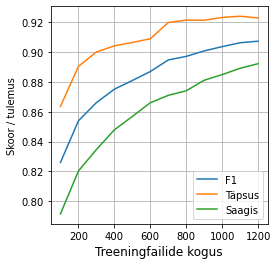

In [15]:
fig = plt.figure()
plt.plot(line_graph)
plt.grid(True)
ax = plt.gca()
ax.set_aspect(1/ax.get_data_ratio())
ax.legend(['F1', 'Täpsus', 'Saagis'])

plt.xlabel('Treeningfailide kogus', fontsize=12)
plt.ylabel('Skoor / tulemus')
plt.show()